<a href="https://colab.research.google.com/github/TMihajlov96/LSA/blob/main/LSA_answer_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automatic Answer Assessment using Latent Semantic Analysis (LSA)**

This project is a part of a Master's thesis at the [Social Sciences and Computing](https://rdn.studije.rect.bg.ac.rs/) programme at the University of Belgrade.

In this notebook, we will present the project. We will start with data preparation, and proceed to build the LSA model, analyse the obtained results, and end with answer classification using KNN and evaluation of the classification.

The data for the project was twofold - (1) an English-language textbook in preparation, for subjects 1-4 at the Faculty of Mining and Geology, Univeristy of Belgrade, written by [prof. Dr Lidija Beko](https://rgf.bg.ac.rs/page.php?page=profesori_details&id=3472); (2) participant answers.

Please note that the data used within this project is confidential and will not be shared along with the project.

# Project aims

The main objective of this project is to see to which extent LSA can be used to assess English-language student answers. Specifically, we are interested in a specific language form - definition, and a specific language domain - geology.

# Importing the necessary libraries and packages

For data preparation purposes, we will use [SpaCy](https://https://spacy.io/) and [NLTK](https://www.nltk.org/) libraries, along with [regular expressions (RegEx)](https://docs.python.org/3/library/re.html). For data manipulation, [Pandas](https://pandas.pydata.org/) library will be employed, while [NumPy](https://numpy.org/) library will be used for data analysis.

The LSA and KNN models and model evaluation will be conducted using [SciKit-Learn](https://scikit-learn.org/stable/).

Lastly, for data visualisation, we will use [Matplotlib](https://matplotlib.org/) and [Seaborn](https://https://seaborn.pydata.org/).

In [1]:
# Importing libraries and packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

import string
import PIL
from wordcloud import WordCloud, STOPWORDS

# Downloading packages if needed

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Importing the data

The data is imported by [mounting](https://stackoverflow.com/questions/47320052/load-local-data-files-to-colaboratory) GoogleDrive with GoogleColab notebook. However, we did leave a part of the code for the drag-and-drop method of importing data. 

The data is comprised of three parts:


*   Texts from each unit of the textbook - 3 texts for 12 units (36 texts in all)
*   Vocabulary following each text - general vocabulary (663 words), geological vocabulary (280 words), and minerals (18 words)
*   Participant answers



In [2]:
# Mounting the Drive to the notebook

from google.colab import drive 

drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


## Importing unit texts

First, we will import unit texts in a from of a dataframe, containing unit number, unit headline, part of the unit a text belogs to, text headline, and the text itself.


In [3]:
# Importing units
import os
from os import path

# Unit - the unit that the text belogs to
# UnitHeadline - headline of the unit
# Part - each unit has three texts, this column gives us information about text order for each unit
# TextHeadline - headline of each text
# Text - raw unit text

path = "/content/gdrive/MyDrive/data/units.csv"
units = pd.read_csv(path, encoding= "utf-8") 
units.head()

,Unit,UnitHeadline,Part,TextHeadline,Text
0,Unit 1,Continental drift,Part one,Mineral evolution,"That’s how it all began, scientists believe, a..."
1,Unit 1,Continental drift,Part two,Physical property,Minerals are formed by natural geological proc...
2,Unit 1,Continental drift,Part three,Chemical property,"Everything that exists within the lithosphere,..."
3,Unit 2,Fossils through times,Part one,Fossil formation and Palynology,Geologists refer to the remains of a once-livi...
4,Unit 2,Fossils through times,Part two,Palaeozoic Era,Palaeontological Eras \r\nMuch later in geolog...


In [4]:
# If we are importing the file locally
"""
vocab = pd.read_csv("units.csv", encoding = "utf-8")
vocab.head()
"""

'\nvocab = pd.read_csv("units.csv", encoding = "utf-8")\nvocab.head()\n'

In [5]:
# Making a list with all texts
texts = units["Text"].tolist()
print("Text:", texts[0][0:300]) # printing texts
print("List lenght:", len(texts)) # checking lenght of the list

Text: That’s how it all began, scientists believe, around 13.77 billion years ago. Our own part, as geologists, in this ongoing story began much more recently with the systematization of the scientific study of the Earth in the 18th century. Earth science began to investigate the air we breathe and the wa
List lenght: 36


In [6]:
texts[0][0:300]

'That’s how it all began, scientists believe, around 13.77 billion years ago. Our own part, as geologists, in this ongoing story began much more recently with the systematization of the scientific study of the Earth in the 18th century. Earth science began to investigate the air we breathe and the wa'

In [7]:
# Extracting text headlines to a list
headlines = units["TextHeadline"].tolist()
headlines_txt = []

# Removing whitespace and punctuation from text headlines, and converting them to lowercase
for headline in headlines:
    headline = headline.lstrip().replace("–", " ").replace("’", " ").replace(":", " ").lower()
    headlines_txt.append(headline)

# Making a new column TextHeadlineClean and adding formatted headlines to it
units.insert(4, "TextHeadlineClean", headlines_txt)
units.head()

,Unit,UnitHeadline,Part,TextHeadline,TextHeadlineClean,Text
0,Unit 1,Continental drift,Part one,Mineral evolution,mineral evolution,"That’s how it all began, scientists believe, a..."
1,Unit 1,Continental drift,Part two,Physical property,physical property,Minerals are formed by natural geological proc...
2,Unit 1,Continental drift,Part three,Chemical property,chemical property,"Everything that exists within the lithosphere,..."
3,Unit 2,Fossils through times,Part one,Fossil formation and Palynology,fossil formation and palynology,Geologists refer to the remains of a once-livi...
4,Unit 2,Fossils through times,Part two,Palaeozoic Era,palaeozoic era,Palaeontological Eras \r\nMuch later in geolog...


We extracted text headlines from the dataframe, removed punctuation and converted them to lowercase, and then put them back in the dataframe in a new column - *TextHeadlineClean*, for later use.

## Importing vocabulary

After unit texts, we are importing vocabulary following each of the texts.

In [8]:
# We are importing the textbook vocabulary

# Term - the defined word
# Unit - the unit where the word is defined
# Category - academic, geological or minerals
# PoS - part of speech
# Definition Part 1 - the first part of the word definition pertaining to the general category the word belongs to
# Deinition Part 2 - the second part of the word definition pertaining to specific characteristics of the notion
# Synonyms - a list of synonyms for the target word
# Antonyms - a list of antonyms for the target word
# Problem - the reason why the definiton cannot be split in part 1 and part 2

path = "/content/gdrive/MyDrive/data/vocabulary.csv" # copying the link to the file
vocab = pd.read_csv(path, encoding= "utf-8") # loading the data as a Padnas data fame
vocab.head() # displaying first 5 rows of the data

,Term,Unit,Category,PoS,Definition Part 1,Definition Part 2,Synonyms,Antonyms,Problem
0,abundant,Unit 1,academic,adjective,in large amounts,NaN,"plentiful, ample, bountiful, copious","minimal, scant, deficient, insufficient",prekratko
1,according to,Unit 1,academic,preposition,as explained by,NaN,NaN,NaN,prekratko
2,according to,Unit 1,academic,preposition,"following, depending on",NaN,NaN,NaN,prekratko
3,accretion,Unit 1,academic,noun,a gradual growth or buildup,by accumulation of different parts or layers,"buildup, accumulation, increase, development","depletion, diminishment, decrease, reduction\r\n",NaN
4,affect\r\n,Unit 1,academic,verb [transitive],an act of,influencing something or someone,"impact, influence, modify, induce","not affect, not influence, ignore",NaN


In [9]:
# If the file is imported locally
"""
vocab = pd.read_csv("vocabulary.csv", encoding = "utf-8")
vocab.head()
"""

'\nvocab = pd.read_csv("vocabulary.csv", encoding = "utf-8")\nvocab.head()\n'

In [10]:
# Dropping unnecessary columns

vocab1 = vocab.drop(columns = "Problem") # dropping the Problem column
vocab1 = vocab1[vocab1["Definition Part 2"].notna()] # dropping empty rows
vocab1.reset_index(inplace = True) # reseting data frame index
vocab1.drop(columns = "index", inplace = True) # dropping the old index column 
vocab1.head() # displaying first 5 rows of the data

,Term,Unit,Category,PoS,Definition Part 1,Definition Part 2,Synonyms,Antonyms
0,accretion,Unit 1,academic,noun,a gradual growth or buildup,by accumulation of different parts or layers,"buildup, accumulation, increase, development","depletion, diminishment, decrease, reduction\r\n"
1,affect\r\n,Unit 1,academic,verb [transitive],an act of,influencing something or someone,"impact, influence, modify, induce","not affect, not influence, ignore"
2,alongside,Unit 1,academic,adverb / preposition,used for describing,a parallel position in time or space,"parallel to, with, next to, beside","without, away from, not near, apart from"
3,although,Unit 1,academic,conjunction,an introduction of,an opposing statement,"though, despite, \r\nalbeit, notwithstanding\r\n","being that, seeing as, since, given that"
4,apatite,Unit 1,mineral,noun,a hexagonal mineral,usually present as an accessory mineral in ign...,NaN,NaN


We have removed the *Problem* column, which was used for the author's internal notes and is not needed for further work. After this, we deleted all rows where there is no data (NaN) in the *Definiton Part 2* column, i.e. where the definition could not be divided into two parts, because we are only interested in definitions that have a specific first and second part, i.e. follow the structure - 1 .the group to which the topic being explained belongs, 2. characteristics that distinguish the topic from others within the same group.

## Importing participant answers

The third part of our data is participant answers elicited by tests distributed using the Moodle platform of the Faculty of Mining and Geology.

In [11]:
# Importing participant answers

# IspitanikID - a unique numeric ID for each of the participants
# BrojPitanja - a number containing a test group and a quesiton number
# PitanjeID - a numeric ID for each quesiton type
# Unit - a textbook unit in which the elicited word is defined
# Pitanje - the target word that is to be defined
# Odgovor - participants' answers
# Poeni - points assigned by the Moodle platform
# PoeniMax - a maximum number of points for each quesiton as attributed by the Moodle platform
# ProcenaMoodle - answer assessment obtained via Moodle
# MoodleTN - answer label, either correct or incorrect, assigned by Moodle
# ProcenaEval - a five cateogry scale grade for each answer assigned by the evaluator
# ProcenaEvalTN - correct and incorrect labels as assigned by the evaluator
# Saglasnost - agreement between Moodle and evaluator assessment

path = "/content/gdrive/MyDrive/data/odgovori.csv" # # copying the link to the file
answers = pd.read_csv(path, encoding= "utf-8") # loading the data as a padnas data frame
answers.head() # displaying first 5 rows of the data

,Ime i prezime,IspitanikID,BrojPitanja,PitanjeID,Unit,Pitanje,Odgovor,Poeni,PoeniMax,ProcenaEval,ProcenaMoodle,MoodleTN,ProcenaEvalTN,Saglasnost
0,Nikola Gudžić,6,1.10.,10,Unit 7,aerate,"deoxygenate, block from air, dimness",2.0,3.0,4,0,N,N,True
1,Igor Miljanović,1,1.10.,10,Unit 7,aerate,"block from air, deoxygenate, poor",2.0,3.0,4,0,N,N,True
2,Jovana Rađenović,2,1.10.,10,Unit 7,aerate,"block from air, deoxygenate, close up",3.0,3.0,5,1,T,T,True
3,Nikola Gudžić,6,1.10.,10,Unit 7,impermeable,"permeable, porous, penetrable, passable",4.0,4.0,5,0,N,T,False
4,Igor Miljanović,1,1.10.,10,Unit 7,impermeable,"penetrable, porous, permeable, close up",3.0,4.0,4,1,T,N,False


In [12]:
# If the file is imported locally

"""
answers = pd.read_csv("MoodleOdogovriLSA.csv", encoding = "utf-8")
answers.head()
"""

'\nanswers = pd.read_csv("MoodleOdogovriLSA.csv", encoding = "utf-8")\nanswers.head()\n'

In [13]:
# We are removing the unncessarry columns from the data frame

answers1 = answers.drop(columns = ["Poeni", "PoeniMax", "ProcenaMoodle", "BrojPitanja", "Saglasnost"])
display(answers1.shape) # checking the number of rows and columns in the df
display(answers1.head()) # displaying first 5 rows of the df

(238, 9)

,Ime i prezime,IspitanikID,PitanjeID,Unit,Pitanje,Odgovor,ProcenaEval,MoodleTN,ProcenaEvalTN
0,Nikola Gudžić,6,10,Unit 7,aerate,"deoxygenate, block from air, dimness",4,N,N
1,Igor Miljanović,1,10,Unit 7,aerate,"block from air, deoxygenate, poor",4,N,N
2,Jovana Rađenović,2,10,Unit 7,aerate,"block from air, deoxygenate, close up",5,T,T
3,Nikola Gudžić,6,10,Unit 7,impermeable,"permeable, porous, penetrable, passable",5,N,T
4,Igor Miljanović,1,10,Unit 7,impermeable,"penetrable, porous, permeable, close up",4,T,N


In [14]:
# Displaying indexes of unanswered questions
answ_na = answers1.loc[answers1["Odgovor"].isna()].index
# Displaying the number of unanswered questions
answ_na_sum = answers1["Odgovor"].isna().sum()
display(answ_na)
display(answ_na_sum)
# Displapying participant and questoind ID for unanswered questions
answ_na = answers1["Odgovor"].isna()
display(answers1.loc[answ_na, ["IspitanikID", "PitanjeID", "Pitanje", "Odgovor"]])


Int64Index([ 13,  15,  17,  19,  72,  75,  78,  80,  81,  84,  87,  90,  93,
             96,  99, 105, 124, 126, 130, 133, 136, 139, 142, 143, 147, 148,
            149, 190, 192, 194, 196, 200, 202, 204, 206, 207, 208, 210, 226,
            227, 229, 230, 231, 232, 233, 234, 235, 236, 237],
           dtype='int64')

49

,IspitanikID,PitanjeID,Pitanje,Odgovor
13,1,3,backlash,NaN
15,1,3,chemical weathering,NaN
17,1,3,malleability,NaN
19,1,3,transpire,NaN
72,1,8,chondrite,NaN
75,1,8,drought,NaN
78,1,8,emphasise,NaN
80,6,8,loess,NaN
81,1,8,loess,NaN
84,1,8,mineral,NaN


Text(0.5, 1.0, 'The number of answered and unanswred questions')

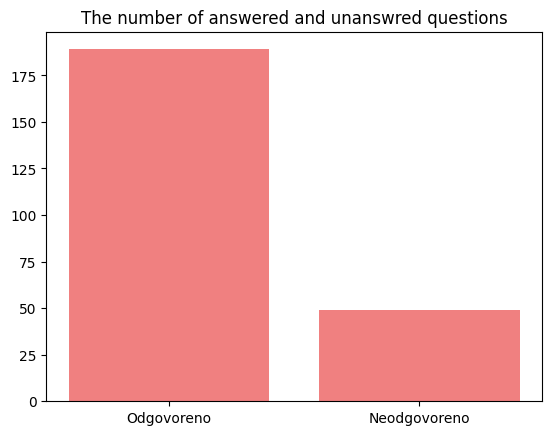

In [15]:
# Visualising the number of answered and unanswered questions
rows_count = len(answers1.index) # counting the number of answers
answered_q = rows_count - answ_na_sum # deducing unanswered questions from the number of answeres to get the number of answred questions
odgovoreno = ["Odgovoreno", "Neodgovoreno"] # adjusting the x axis
num_answ = [answered_q, answ_na_sum] # adjusting the bar height
num_answ_plt = plt.bar(odgovoreno, num_answ, color = "lightcoral") # making a bar graph
num_answ_plt = plt.title("The number of answered and unanswred questions") # adding title
# Displaying the plot
num_answ_plt

In [16]:
# Removing the unanswred questions from our data frame

answers1.dropna(subset=["Odgovor"], inplace=True) # removing the unanswered questions
print("Data frame shape prior to removing the unanswered questions: ", answers.shape) # data frame shape before the removal
print("Data frame shape after removing the unanswered questions: ", answers1.shape) # data frame shape after the removal

Data frame shape prior to removing the unanswered questions:  (238, 14)
Data frame shape after removing the unanswered questions:  (189, 9)


After removing the unanswred questions, we are left with 189 participant answeres. The next step is to remove those questions that cannot be analysed using LSA. Because LSA is generally not good in detecting synonyms and antonyms, we removed the questions were the participants were supposed to detect synonyms or antonyms for the target words. We will only leave the open-answer questions, because they are suitable for analysis using LSA.

In [17]:
# Removing the answers to the questions that cannot be analysed by LSA
answers1 = answers1.loc[answers1["PitanjeID"].isin([3, 6, 7, 8])]
answers1.head()

,Ime i prezime,IspitanikID,PitanjeID,Unit,Pitanje,Odgovor,ProcenaEval,MoodleTN,ProcenaEvalTN
12,Igor Miljanović,1,3,Unit 7,unconsolidated,"incoherent, loose, unstratified",3,N,T
14,Jovana Rađenović,2,3,Unit 3,backlash,adverse reaction to a recent development,4,T,T
16,Jovana Rađenović,2,3,Unit 6,chemical weathering,erosion or disintegration of rocks caused by c...,4,N,T
18,Jovana Rađenović,2,3,Unit 1,malleability,altered or shaped by external forces,4,N,T
20,Jovana Rađenović,2,3,Unit 10,transpire,releasing liquid through openings in leaves of...,4,N,T


After removing the questions not suitable for LSA analysis, we are left with 72 participant answers, which is a relatively small data set.

# Data preparation

In this section, we will prepare the data for further processing - i.e. for creating a TF-IDF matrix and application of SVD to it. The first step in data preparation will be lemmatisation of all parts of the data based on previos PoS tagging. After that, we will remove noise from the texts, including punctuation, numbers, extra whitespace and other characters that represent noise in the data.

### Lemmatisation of unit texts

For lemmatisation purposes, the SpaCy library was employed. The lemmatisation is based on previos part-of-speech (PoS) tagging, which means that the model first tokenised the text, then determined PoS for each token, and relaying on that information produced a word lemma. Kako bismo pripremili korpus za model, izvršili smo lematizaciju koriščenjem spaCy bibloteke. Lematizacija korpusa Without PoS tagging, lemmatiser treats each word as a noun, meaning it cannot detect different verb-, pronoun adjective forms.

We disabled the Named Entitiy Recognition option while lemmatising (`disable = "ner"`). On this [link](https://github.com/wjbmattingly/topic_modeling_textbook/blob/main/03_03_lda_model_demo.ipynb ), you can find the code we used as the source code.

In [18]:
# Importing the Spacy library
import spacy

# Creating the text lemmatisation function

def lemmatization(texts):
    nlp = spacy.load("en_core_web_sm", disable = "ner") # setting the parameters
    corpus = [] # an empty list for saving lemmatised surrogats of original text
    for text in texts: 
        doc = nlp(text) # applying the lemmatisation function to each text
        corpus_tok_pos = [] # an empty list for saving tokens with their respective PoSes
        for token in doc:
          corpus_tok_pos.append(token.lemma_) # saving token lemmas
        corpus.append(" ".join(corpus_tok_pos)) # joining the tokens back to text
    
    return (corpus)

# Applying the lemmatisation function to unit texts
texts_lemma = lemmatization(texts)

# Printing one lemmatised text and checking the lenght of the lemmatised text list
print(texts_lemma [0][0:1000])
print(len(texts_lemma))

that ’ how it all begin , scientist believe , around 13.77 billion year ago . our own part , as geologist , in this ongoing story begin much more recently with the systematization of the scientific study of the Earth in the 18th century . earth science begin to investigate the air we breathe and the water that surround our continent ; the land itself , the rock , mineral , soil , the geographical feature such as mountain range and desert ; the live creature with which we share our planet – every aspect of the Earth . earth scientist , like their colleague in other field , have develop a scientific method base on observation and collection of datum , formulation and testing of hypothesis , lead to the formulation of law or principle . 
 this study expand in the 1950 , as humanity begin to explore space . one aspect of this expansion have be that Earth could now be study from a new perspective , use instrument carry into orbit by satellite . this have result in an increase ability to te


As we can see, after lemmatisation, the plural of nouns, e.g. *three geological period*, were removed from the text, and the verbs were transferred to the infinitive, e.g. *they be the triassic*. 

By reviewing several texts, we concluded that the words that belong to the general, and those that belong to the domain, geological vocabulary are equally well lemmatised. However, the Latin plurals of nouns were not transferred to the singular, so for example the plural *millennia* remained unchanged `(texts_lemma[6])`, then *strata* was also not transferred to the singular form *stratum*, `(texts_lemma[7])` .

### Lemmatisation of vocabulary

Next, we will apply the `lemmatization` function to our terms, first and second part of the definition, and synonyms. We expect that word form in terms and synonyms will remain the same.

In [19]:
# We are extracting terms and definitons to a list

terms = vocab1.Term.tolist() # making a list with all terms
def1 = vocab1["Definition Part 1"].tolist() # making a list with the first part of each definition
def2 = vocab1["Definition Part 2"].tolist() # making a list with the second part of each definition
synonyms = vocab1.Synonyms.tolist() # making a list with all synonyms

# Removing NaN values from synonyms
syn= [] # making a new list
for synonym in synonyms:
  synonym = str(synonym) # converting synonyms to a string
  if synonym:
    syn.append(synonym) # adding synonyms to the new list

# Applying the lemmatization function to our definitions

terms_lemma = lemmatization(terms) # term lemmatisation
def1_lemma = lemmatization(def1) # lemmatising the first part of the definition
def2_lemma = lemmatization(def2) # lemmatising the second part of the definition
syn_lemma = lemmatization(syn)  # synonym lemmatisation

# Printing 20 lemmatised elements for each part of the vocabulary
print("Unlemmatised terms:", terms[:20]) 
print("Term lemmas:", terms_lemma[:20])
print("List lenght:", len(terms_lemma))     
print("Lemmatised definitions - first part:", def1_lemma[:20]) 
print("List lenght:", len(def1_lemma))
print("Lemmatised definitions - second part:", def2_lemma[:20])
print("List lenght:", len(def2_lemma))
print("Unlemmatised synonyms:", syn[:20]) 
print("Synonym lemmas:", syn_lemma[:20])
print("List lenght:", len(syn_lemma)) 

Unlemmatised terms: ['accretion ', 'affect\r\n', 'alongside ', 'although ', 'apatite ', 'apply ', 'arrange ', 'asbestos ', 'atmosphere ', 'believe ', 'beryl ', 'biosphere ', 'bond ', 'brittle ', 'build up ', 'build up ', 'capacity ', 'chondrite ', 'classify ', 'clay  ']
Term lemmas: ['accretion', 'affect \r\n', 'alongside', 'although', 'apatite', 'apply', 'arrange', 'asbestos', 'atmosphere', 'believe', 'beryl', 'biosphere', 'bond', 'brittle', 'build up', 'build up', 'capacity', 'chondrite', 'classify', 'clay  ']
List lenght: 885
Lemmatised definitions - first part: ['a gradual growth or buildup', 'an act of', 'use for describe', 'an introduction of', 'a hexagonal mineral', 'an act of', 'an act of', 'a silicate mineral', 'a mixture of gas', 'an action of', 'a mineral', 'a layer of the Earth', 'the link between two atom', 'use for describe something', 'make something sound', 'use word', 'ability', 'a stony meteorite', 'an act of splitting into category', 'a group of mineral']
List lenght

As expected, no differences are detected between unlemmatised and lemmatised terms and synonyms. When it comes to definitions, as well as the lemmatization of texts, we can notice that verbs are transferred to the infinitive, e.g. *used* in *use*, and nouns in the singular - say *parts* in *part*.

### Lemmatisation of participant answers

In this part, we will apply the `lemmatization' funtion to questions and answers. As in terms and synonyms, we expect no changes in forms of quesitons after lemmatization, since questions already have basic word form. Nonetheless, we apply the function to all parts of the data, in case there are differences between basic word forms in the data and lemmas assigned by SpaCy.

In [20]:
# Extracting and lemmatising questions
q = answers1.Pitanje.tolist() # making a list with all questions
q_lemma = lemmatization(q) # applying the lemmatization function

# Extracting and lemmatising answers
answ = answers1.Odgovor.tolist() # making a list with all answers
answ_lemma = lemmatization(answ) # applying the lemmatization function

# We are displaying first 20 lemmatised questions and answers
print("Unlemmatised questions:", q[:20]) 
print("Questions lemmas:", q_lemma[:20])
print("List lenght:", len(q_lemma))
print("Lemmatised answers:", answ_lemma[:20]) 
print("List lenght:", len(answ_lemma))

Unlemmatised questions: ['unconsolidated ', 'backlash ', 'chemical weathering', 'malleability', 'transpire', 'unconsolidated ', 'global warming', 'global warming', 'global warming', 'global warming', 'global warming', 'sedimentary rocks', 'sedimentary rocks', 'sedimentary rocks', 'sedimentary rocks', 'chondrite', 'chondrite', 'drought ', 'drought ', 'emphasise ']
Questions lemmas: ['unconsolidated', 'backlash', 'chemical weathering', 'malleability', 'transpire', 'unconsolidated', 'global warming', 'global warming', 'global warming', 'global warming', 'global warming', 'sedimentary rock', 'sedimentary rock', 'sedimentary rock', 'sedimentary rock', 'chondrite', 'chondrite', 'drought', 'drought', 'emphasise']
List lenght: 72
Lemmatised answers: ['incoherent , loose , unstratified', 'adverse reaction to a recent development', 'erosion or disintegration of rock cause by chemical reaction', 'alter or shape   by external force', 'release liquid through opening in leave of a plant', 'unstratif

In the question, the differences between the original and the lemmatised text were observed only in the example *unconsolidated*, which SpaCy recognized as the past participle of the verb, and thus lemmatised it, where we now get the form *unconsolidate*.

In the answers, we can see that the plural has been transferred to the singular, e.g. *pieces* in *piece*, and the past tense of the verbs *left* and *destroyed* in the infinitive leave, in the example 'piece of waste material leave after something have be use or destroy' As we can see, the model lemmatized equally well the regular and irregular verbs.

### Removing noise from unit texts

To get our data ready for LSA, noise, such as punctuation, extra whitespace, bullet points etc., needs to be removed.

For this, we will use `.replace()` function and regular expressions.

After this step, our data will be ready for TF-IDF matrx.

In [21]:
# Importing libraries
import tqdm
import re

# Defining the text normalization function

def clean_text(units):
      norm_units = []
      for unit in tqdm.tqdm(units): 
        # removing extra whitespace and special characters
        unit = unit.replace("\n\n", " ").replace("•\t", "").replace("\t", "").replace("→", " ").replace("°", " ").replace("–", " ").replace("-", " ").replace (">", " ").replace("Unit [0-9]*", " ").replace("\r\n", " ").replace("’", "")
        unit = unit.lower() # coverting text to lowercase
        unit = unit.translate(str.maketrans(" ", " ", string.punctuation)) # removing puntuation
        unit = "".join([word for word in unit if not word.isdigit()]) # removing numbers
        unit = unit.strip() # removing extra whitespace from beginning and end of a string
        unit = re.sub(" +", " ", unit) # removing extra whitespace after each word
        if unit:
          norm_units.append(unit) # appending normalized text to a new list
      
      return(norm_units) # returning normalized texts

# Applying the normalization function to unit texts
texts_clean = clean_text(texts_lemma)

# Printing the first normalized text
print(texts_clean[0][0:1000])

100%|██████████| 36/36 [00:00<00:00, 302.91it/s]

that how it all begin scientist believe around billion year ago our own part as geologist in this ongoing story begin much more recently with the systematization of the scientific study of the earth in the th century earth science begin to investigate the air we breathe and the water that surround our continent the land itself the rock mineral soil the geographical feature such as mountain range and desert the live creature with which we share our planet every aspect of the earth earth scientist like their colleague in other field have develop a scientific method base on observation and collection of datum formulation and testing of hypothesis lead to the formulation of law or principle this study expand in the as humanity begin to explore space one aspect of this expansion have be that earth could now be study from a new perspective use instrument carry into orbit by satellite this have result in an increase ability to test and prove hypothesis and also create new way of study the int

As we can see, the text is converted to lowercase and additional noise, i.e. puntuation, bulletpoints etc. is removed. With verb abbreviations, the apostrophe is left.

In [22]:
# We are creating a new column in units dataframe and adding normalized texts to it
units.insert(6, "TextClean", texts_clean)
units.head()

,Unit,UnitHeadline,Part,TextHeadline,TextHeadlineClean,Text,TextClean
0,Unit 1,Continental drift,Part one,Mineral evolution,mineral evolution,"That’s how it all began, scientists believe, a...",that how it all begin scientist believe around...
1,Unit 1,Continental drift,Part two,Physical property,physical property,Minerals are formed by natural geological proc...,mineral be form by natural geological process ...
2,Unit 1,Continental drift,Part three,Chemical property,chemical property,"Everything that exists within the lithosphere,...",everything that exist within the lithosphere h...
3,Unit 2,Fossils through times,Part one,Fossil formation and Palynology,fossil formation and palynology,Geologists refer to the remains of a once-livi...,geologist refer to the remain of a once live o...
4,Unit 2,Fossils through times,Part two,Palaeozoic Era,palaeozoic era,Palaeontological Eras \r\nMuch later in geolog...,palaeontological eras much later in geological...


Lemmatized text without noise is added to the `TextClean` column of the dataframe.

### Removing noise from the vocabulary

In this section, we will lemmatize each part of the vocabulary - terms, synonyms, first and second part of the definition. Afetr that, we will apply the `clean_text` funtion to the lemmatized vocabulary.

In [23]:
# Applying the lemmatization function to the vocabulary

terms_clean = clean_text(terms_lemma) # lemmatizing terms
def1_clean = clean_text(def1_lemma) # lemmatizing first part of definitions
def2_clean = clean_text(def2_lemma) # lemmatizing second part of definitions
syn_clean = clean_text(syn_lemma) # lemmatizing synonyms

# We are printing the lemmatized data and checking the length of each list

print("Cleaned terms:", terms_clean[:20])
print("List length:", len(terms_clean))
print("Cleaned first part of the definitions:", def1_clean[:20])
print("List lengt:", len(def1_clean[:10]))
print("Cleaned second part of the definitions:", def2_clean[:20])
print("List lengt:", len(def2_clean))
print("Cleaned synonyms:", syn_clean[:20])
print("List lengt:", len(syn_clean))

100%|██████████| 885/885 [00:00<00:00, 43971.18it/s]

Cleaned terms: ['accretion', 'affect', 'alongside', 'although', 'apatite', 'apply', 'arrange', 'asbestos', 'atmosphere', 'believe', 'beryl', 'biosphere', 'bond', 'brittle', 'build up', 'build up', 'capacity', 'chondrite', 'classify', 'clay']
List length: 885
Cleaned first part of the definitions: ['a gradual growth or buildup', 'an act of', 'use for describe', 'an introduction of', 'a hexagonal mineral', 'an act of', 'an act of', 'a silicate mineral', 'a mixture of gas', 'an action of', 'a mineral', 'a layer of the earth', 'the link between two atom', 'use for describe something', 'make something sound', 'use word', 'ability', 'a stony meteorite', 'an act of splitting into category', 'a group of mineral']
List lengt: 10
Cleaned second part of the definitions: ['by accumulation of different part or layer', 'influence something or someone', 'a parallel position in time or space', 'an opposing statement', 'usually present as an accessory mineral in igneous rock metamorphic rock and ore de

As displayed above, when removing noise from terms containig latin forms and singular and plural abbreviations, such as *'data sing datum'* i *'hypothesis pl hypotheses'*, the noise was not removed. Because we will later use vocabulary and quesiton lemmas as comparison criteria for definition-answer similarity, we should remove this.

To additionally clean terms, we are defining the `clean_add` function.

In [24]:
# Defining a function for removing singular and plural abbreviations along with one word after them

def clean_add(texts):
  cleaned_text = [] # making a new list
  for text in texts:
    text = re.sub("sing [a-z]*", "", text) # removing singular label and form
    text = re.sub("(pl [a-z]*)", "", text) # removing plural label and form
    text = re.sub(" +", " ", text) # removing extra witespace
    text = text.strip()
    if text:
      cleaned_text.append(text) # saving cleaned terms in a new list
      
  return(cleaned_text)

# Applying the function to terms
terms_clean1 = clean_add(terms_clean)

# Printing terms and checking list lenght
print("Terms:", terms_clean1[:20])
print("List lenght:", len(terms_clean1))

Terms: ['accretion', 'affect', 'alongside', 'although', 'apatite', 'apply', 'arrange', 'asbestos', 'atmosphere', 'believe', 'beryl', 'biosphere', 'bond', 'brittle', 'build up', 'build up', 'capacity', 'chondrite', 'classify', 'clay']
List lenght: 885


Checking thorugh terms afer applying the `clean_add` function, we determined that Latin singular and plural lables and forms were removed, so now we have only the basic forms of words - *'data', 'hypothesis'*.

After we cleaned all parts of vocabulary, we are concatenating term, first and second part of the definition and synonyms, to get a complete word definiton for each of the defined terms in our textbook vocabulary.

Our reasoning behind this step is as follows - in order to be able to compare definitons with participant answers, we need them to be comprised of same parts. Since not all answers can be split in first and second part, it is more logical to concatenate vocabulary definitons. Secondly, it would be more difficult to assing topics to split definitions.

In [25]:
# Concatenating vocabulary parts to get complete word definitons
# source code: 
# https://www.geeksforgeeks.org/python-concatenate-two-lists-element-wise/ 

definition = [] # making a new list
for trm, d1, d2 in zip(terms_clean1, def1_clean, def2_clean): # iterating thrugh list of terms, first and second parts of definitons
  dd = trm + " " + d1 + " " + d2 # concatenating lists element by element and adding whitespace between each part
  if dd:
    definition.append(dd) # appending concatenated defnitions to a new list
    def_list = [] # making a list for adding synonyms
    for df, s in zip(definition, syn_clean): # itterating through lists of definitions and synonyms
      if s in "nan": # if there is no synonym, we are appending only word definiton to a new list
        def_list.append(df)
      else: # if a word has synonyms 
        dd1 = df + " " + s  # we concatenate definitons and synonyms
        if dd1:
          def_list.append(dd1) # and then append definitions with synonyms to a new list
          defs = sorted(def_list) # sorting list A-Z

# Printing complete definiotns with synonyms and checking list lenght
print(defs[:20])
print("List lenght: ", len(defs))


['abiotic use for describe something occur in nature that be not live', 'abnormal use for describe something differ from the expect or usual especially in a negative way atypical uncommon unusual anomalous', 'above mention use for refer to something previously state aforementione as state above as previously say', 'abrade an action of wear away or rub off something by friction chafe erode grate scrape', 'abrade the act of rub against the surface of something thereby wear it away scrape rub erode', 'abrupt refer to something that bring about sudden action or change unexpected quick hasty out of the blue', 'absence the state of not be present physically or mentally nonattendance vacancy failure to appear', 'absorb an action of take in something so it become a part of it in some form soak assimilate consume suck in', 'abundance a quantity of something which be more than sufficient plenty a lot affluence profusion', 'accelerate an action of speed something up expedite quicken rush hasten',

As we can see, list lenght remained the same as lenght of the vocabulary dataframe, so we can conclude that no data was lost during concatenation. Each straing in `defs` contains in the following order - the defined term, first part of the definition, second part of the definion, synonyms.

We are making a new dataframe `vocab_df` with definitions, and setting terms as indexes in a dataframe `vocab_df1`.

In [26]:
# Creating a dataframe with word defnitions

vocab_df = pd.DataFrame({"Definition" : sorted(defs), # creating definions column containing word definitions
                         "Term" : sorted(terms_clean1)}) # creating terms column containing terms
# We are concatenating different meanings of the same word to one definion
vocab_df1 = vocab_df.groupby(vocab_df["Term"]).aggregate(','.join)
# Making a new list with concatanted definitions
def_final = vocab_df1["Definition"].tolist()
# Checking dataframe shape
print(vocab_df1.shape)
# Displaying first 5 rows of the dataframe
vocab_df1.head()

(844, 1)


,Definition
Term,
abiotic,abiotic use for describe something occur in na...
abnormal,abnormal use for describe something differ fro...
above mention,above mention use for refer to something previ...
abrade,abrade an action of wear away or rub off somet...
abrupt,abrupt refer to something that bring about sud...


### Removing noise from participant answers

Lastly, we are applying the `clean_text` function to lemmatized answers. 

In [27]:
# Applying clean_text function to lemmatized quesitons and answers
q_clean = clean_text(q_lemma) # normalizing questions
answ_clean = clean_text(answ_lemma) # normalizing answers

# Printing the normalized quesitons and answers and cheking list lenghts
print(" ")
print("Cleaned questions:", q_clean[:20]) 
print("List lenght:", len(q_clean))
print("Cleaned answers:", answ_clean[:20]) 
print("List lenght:", len(answ_clean))

100%|██████████| 72/72 [00:00<00:00, 33004.36it/s]

 
Cleaned questions: ['unconsolidated', 'backlash', 'chemical weathering', 'malleability', 'transpire', 'unconsolidated', 'global warming', 'global warming', 'global warming', 'global warming', 'global warming', 'sedimentary rock', 'sedimentary rock', 'sedimentary rock', 'sedimentary rock', 'chondrite', 'chondrite', 'drought', 'drought', 'emphasise']
List lenght: 72
Cleaned answers: ['incoherent loose unstratified', 'adverse reaction to a recent development', 'erosion or disintegration of rock cause by chemical reaction', 'alter or shape by external force', 'release liquid through opening in leave of a plant', 'unstratifie', 'overall temperature increase due to greenhouse gas', 'rise in global temperature of the earth due to carbon dioxide emission', 'global warming be the process of heat earth due to fossil fuel burn and other human activity', 'global warming occur when carbon dioxide co and other air pollutant collect in the atmosphere and absorb sunlight and solar radiation that hav

In the question, the differences between the original and lemmatized text were observed only in the example *unconsolidated*, which SpaCy recognized as the past participle of the verb, so it was lemmatized, where we now get the form *unconsolidate*.

In the answers, there should also be no differences in the questions asking for synonyms and anotonyms. On the other hand, lemmatization is important for open-ended questions, those questions where respondents are asked to put together parts of the definition. Thus we can see that the plural has been transferred to the singular, e.g. *pieces* into *piece*, and the past tense of the verbs *left* and *destroyed* into the infinitive *leave* and *destroy*, in the example of *piece of waste material leave after something have been used or destroyed*. As we can see, the model lemmatized both regular and irregular verbs equally well.

In [28]:
answers1.sort_values(by = ["Pitanje"], axis = 0, ascending = True, # soring the dataframe A-Z by questions
                          inplace = True)
answers1.reset_index(drop = True, inplace = True)
answers1.head()

,Ime i prezime,IspitanikID,PitanjeID,Unit,Pitanje,Odgovor,ProcenaEval,MoodleTN,ProcenaEvalTN
0,Jovana Rađenović,2,3,Unit 3,backlash,adverse reaction to a recent development,4,T,T
1,Igor Miljanović,1,8,Unit 2,cataclysmic,catastrophic,2,N,T
2,Mirjana Banković,3,8,Unit 2,cataclysmic,is used for destruction on a large scale,4,N,T
3,Mirjana Banković,3,8,Unit 8,cavity,"is open space in a limestone cave, or in coal",5,N,T
4,Jovana Rađenović,2,3,Unit 6,chemical weathering,erosion or disintegration of rocks caused by c...,4,N,T


In [29]:
# Creating a dataframe with clean quesitons and answers
# Dodajemo kolone sa ID-jem ispitanika i pitanja, te procenama Moodle-a i evaluatora

answers_final = pd.DataFrame({"Pitanje": q_clean, "Odgovor": answ_clean})    
answers_final.sort_values(by = "Pitanje", axis=0, ascending=True, inplace=True) # sorting by question lemmas                       
answers_final.reset_index(drop = True, inplace = True) # reseting the index
answers_final.insert(0, "IspitanikID", answers1.IspitanikID) # adding ParticipantID
answers_final.insert(1, "PitanjeID", answers1.PitanjeID) # adding QuestionID
answers_final.insert(4, "MoodleTN", answers1.MoodleTN) # adding Moodle answer assessment
answers_final.insert(5, "EvalTN", answers1.ProcenaEvalTN) # Adding evaluator two-category assessment
answers_final.insert(6, "ProcenaEval", answers1.ProcenaEval) # Adding evaluator five-category assessment

# Displaying first 5 columns of the dataframe
answers_final.head() 

,IspitanikID,PitanjeID,Pitanje,Odgovor,MoodleTN,EvalTN,ProcenaEval
0,2,3,backlash,adverse reaction to a recent development,T,T,4
1,1,8,cataclysmic,catastrophic,N,T,2
2,3,8,cataclysmic,be use for destruction on a large scale,N,T,4
3,3,8,cavity,be open space in a limestone cave or in coal,N,T,5
4,2,3,chemical weathering,erosion or disintegration of rock cause by che...,N,T,4


Lemmatized surogat of the original questions and answers is inserted in a new dataframe, answers_final, along with question (`PitanjeID`) and participant ID (`IspitanikID`), Moodle answer assessment (`MoodleTN`), as well as evaluator assessment in two (`EvalTN`) and five categories (`ProcenaEval`)

# Latentna semantička analiza (*Latent Semantic Analysis*, LSA)

Latent Semantic Analysis (LSA) is a theory and method for extraction and representation of word meaning in context, whereby statistical calculations are applied to a large text corpus ([Landauer et al. 1998](https://https://www.researchgate.net/publication/200045222_An_Introduction_to_Latent_Semantic_Analysis))

When creating an LSA model, we start by computing a document-term matrix, thereby forming a semantic space comprised of all terms and all documents in our corpus ([Deerwester et. al 1990](https://https://www.semanticscholar.org/paper/Indexing-by-Latent-Semantic-Analysis-Deerwester-Dumais/20a80a7356859daa4170fb4da6b87b84adbb547f)). The next step is applying a weighting function to each matrix cell, which assigns small weights to high-frequency terms, and high weights to terms that appear in some, but not all documents ([Martin & Berry 2007](https://psycnet.apa.org/record/2007-04818-002)). After this, singular value decomposition (SVD) is performed. This is an instrumental part of LSA, because it makes possible to present word meaning relative to context it appears in ([Lemaire, Benoit & Dessus 2003](https://www.researchgate.net/publication/2879178_A_System_To_Assess_The_Semantic_Content_Of_Student_Essays)).

In this project, we will use the [SciKit-Learn library](https://scikit-learn.org/stable/index.html) to create our LSA model. Examples of LSA implementation using SkLearn can be found at: 
1. https://towardsdatascience.com/latent-semantic-analysis-sentiment-classification-with-python-5f657346f6a3
2. https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8#04db 

In [30]:
# Installing scikit-learn library if needed
#!pip install scikit-learn

# Importing libraries

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline

from os import listdir

## Setting model parameters and creating the model

First, we will define the parameters of the model, based on the reviewed literature and our data, where in the first step we define the list of stop words, then we determine the parameters for creating the TF-IDF matrix, and finally, we set the SVD parameters.

In [31]:
# Defining a stopword list
stop_words = stopwords.words("english") # storing NLTK stopwords for the English language in a variable stop_words

# Creating a stopword list specific for our corpus
stop_words_add = ["km", "cm", "eg", "pl", "sing", "one", "two", "three", "unit", "th", "much", "etc", "ho", "kmh", "metre", "mm", "usa", "well", "yet"]

# Concatenating NLTK and our stopword list
stop_words.extend(stop_words_add)
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

When defining the list of stop words, it was important that, in addition to using `NLTK stopwords`, we also define a list of words specific to our corpus. In this list, we have included units of measurement, which have no role in determining the meaning of the text, numbers, abbreviations, and the adverbs *well* and *yet*, which are often repeated in the corpus. By joining our list and the `NLTK` list, we got the final list of stop words.

#### Setting TF-IDF parameters for unit texts

After this, we set the number of features to describe each document. Also, when creating the TF-IDF matrix, we removed all words that appear in the corpus in more than 80% of documents by setting the `max_df` parameter to 0.8, as well as all words that appear in the corpus less than 3 times by setting `min_df` to 3,and in `ngram_range ` we took into account engrams and bigrams.

In [32]:
# Setting TF-IDF parameters for long texts
num_features = 1000 # setting number of features

# Making TF-IDF model
vectorizer = TfidfVectorizer(max_df = 0.8, min_df = 3, max_features= num_features, stop_words = stop_words, ngram_range = (1,2))

#### Setting SVD parameters

The second step in LSA is Singular Value Decomposition (SVD). This is a key part of LSA, because it enables word representation in reference to the context that word appears in. If *m* and *n* are natural numbers, and *M* is an arbitrary *mn* matrix. Then, decomposition of matrix *M* *m x n* is:

                               M = U x S x VT
where:

*   **M** is an orthogonal *m x n* matrix  (document-term matrix), where *m* is a number of documents and *n* the number of terms
*   **U** is an orthogonal document-topic *m x r* matrix, where *m* is a number of documents and *r* the number of topics
*   **S** is a diagonal *r x r* matrix, in which all values but those on the diagonal are equal to 0. The diagonal values in **S** represent how much each topic explains variance in the data

*   **V** is an orthogonal *n x r* matrix (term-topic), where *n* is the number of documents and *r* is the number of topics.

https://hackernoon.com/advanced-topic-modeling-tutorial-how-to-use-svd-and-nmf-in-python-to-find-topics-in-text 

As shown in the picture below:
([image source](https://medium.com/analytics-vidhya/understanding-of-matrix-factorization-mf-and-singular-value-decomposition-svd-1a38c2d5bbaa))

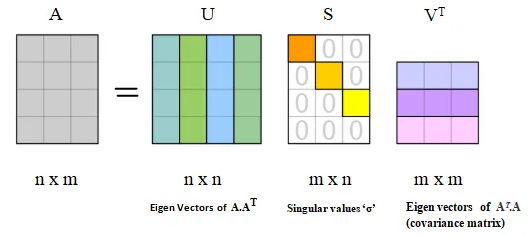

In [33]:
# Setting SVD parameters
algorithm = "arpack"
rand_state = 42
n_iter = 100
num_components = 10 # number of topics
# creating SVD model
svd = TruncatedSVD(n_components = num_components, algorithm = algorithm, random_state = rand_state, n_iter = n_iter)

For TruncatedSVD, we used the `arpack` algorithm modeled after the found projects, for the number of topics we took 10 using the deductive method of evaluating the different topics that our documents include, the number of iterations and the `rand_state` argument were adjusted according to the information found in [library documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

#### Implementation of the model on unit texts

First, we will compute a TF-IDF matrix for unit texts, and then apply SVD to it. We will do both by employing `fit_transform`.

In [34]:
# Computing TF-IDF
texts_tfidf = vectorizer.fit_transform(texts_clean)

# Applying SVD to TF-IDF
lsa_texts = svd.fit_transform(texts_tfidf)
print(texts_tfidf.shape) # shape of TF-IDF for unit texts
print(lsa_texts.shape) # shape of a matrix after applying SVD

(36, 1000)
(36, 10)


As we can see, the TF-IDF matrix has the form 36, 1000 which corresponds to 36 documents (unit texts) described by 1000 terms with the highest weights, while after SVD we get the form 36, 10 - 36 documents and 10 topics.

In [35]:
# Checking SVD matrix shapes
Sigma_texts = svd.singular_values_ 
V_transpose_texts = svd.components_.T

print(Sigma_texts.shape)
print(V_transpose_texts.shape)

(10,)
(1000, 10)


In [36]:
# Extracting terms obtained after SVD
dictionary_texts = vectorizer.get_feature_names_out()
print(dictionary_texts[:100]) # displaying first 100 terms
print(len(dictionary_texts))

['ability' 'able' 'abrasion' 'absorb' 'access' 'accord' 'accumulate'
 'accumulation' 'acid' 'across' 'act' 'action' 'active' 'activity' 'add'
 'advance' 'affect' 'africa' 'age' 'agent' 'ago' 'air' 'align' 'allow'
 'almost' 'along' 'alongside' 'already' 'also affect' 'also know' 'alter'
 'alteration' 'although' 'always' 'america' 'american' 'among' 'amount'
 'analysis' 'ancient' 'angle' 'animal' 'another' 'antarctica' 'apart'
 'appear' 'application' 'apply' 'approximately' 'area' 'arise' 'around'
 'ash' 'associate' 'asthenosphere' 'atmosphere' 'atmospheric' 'atom'
 'atomic' 'atomic number' 'avalanche' 'average' 'away' 'back' 'bacteria'
 'balance' 'band' 'basalt' 'basaltic' 'base' 'basic' 'basin' 'basis'
 'bear' 'become' 'bed' 'bedrock' 'begin' 'begin form' 'belt' 'beneath'
 'beyond' 'billion' 'billion year' 'biological' 'biosphere' 'black'
 'block' 'body' 'body water' 'bond' 'bottom' 'boundary' 'break' 'bring'
 'brittle' 'bubble' 'build' 'building' 'calcium']
1000


In [37]:
# Extracing and displaying 15 terms with highest weights for each topic
# defining a function
def top_words(svd, vocab): 
  for index, component in enumerate(svd.components_): # enumerating each obtained topic
    zipped = zip(vocab, component) # concatenating dictionary and topic
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse = True)[:15]  # sorting terms by weights
    top_terms_list=list(dict(top_terms_key).keys()) # adding sorted terms to a list
    final = print("Topic "+str(index)+": ",top_terms_list) # printing topics and terms with highest weights
  return(final)

top_words(svd, dictionary_texts)

Topic 0:  ['mineral', 'deposit', 'earth', 'cycle', 'flow', 'sedimentary', 'igneous', 'material', 'soil', 'metamorphic', 'begin', 'grain', 'plant', 'metamorphism', 'sediment']
Topic 1:  ['mineral', 'metamorphism', 'metamorphic', 'grain', 'metamorphic rock', 'igneous', 'crystal', 'pressure', 'deposit', 'ore', 'magma', 'chemical', 'metallic', 'thermal', 'colour']
Topic 2:  ['flow', 'glacier', 'soil', 'particle', 'stream', 'slope', 'erosion', 'debris', 'landslide', 'material', 'groundwater', 'glacial', 'sand', 'velocity', 'move']
Topic 3:  ['plate', 'earthquake', 'wave', 'cycle', 'tectonic', 'magma', 'oceanic', 'continental', 'magnetic', 'magnetic field', 'activity', 'earth', 'volcano', 'temperature', 'ridge']
Topic 4:  ['sedimentary', 'cycle', 'sediment', 'igneous', 'metamorphic', 'sedimentary rock', 'strata', 'glacier', 'metamorphic rock', 'erosion', 'metamorphism', 'grain', 'plate', 'igneous rock', 'rock cycle']
Topic 5:  ['magma', 'slope', 'lava', 'volcano', 'eruption', 'volcanic', 'vi

After obtaining the topics, we showed the most frequent terms within each topic, then name them based on the results obtained. As we can see, some topics are more general, such as *Topic0*, which includes terms that span most documents. On the other hand, some topics, such as *Topic3* or *Topic5* and *Topic7* refer to specific areas and concepts from geology, such as tectonic plates, volcanology and erosion, respectively.

We named the topics based on 100 terms with the highest weights for each topic.

In [38]:
# Naming the topics based on terms
topics = ["EarthFormation", "Minerals", "Erosion", "TectonicPlates", "RockFormation", "Volcanology", "Weathering", "Landslides", "Dating", "Fossils"]

In order to see to what extent each topic is represented in each of the documents, we created a `text_u` dataframe that displays the document-topic matrix. The data frame in the first column contains the title of each text (column `TextHeadline`), and the names of the other columns are previously assigned topic names - `topics`. In the cells of the data frame are the values that tell us which topic is represented to what extent in which text.

We were interested in which topics are the most represented for each text, so we defined the function `dominant_topics`, which extracts the 3 largest values for each row in the data frame, which gives us the 3 most dominant topics for each document. The values are written in the columns `MaXValue` (the largest value), `SecondLargest` (the second largest value) and `ThirdLargest` (the third largest value), and then the index of the column in which each of the 3 values is located is extracted, so we get the names dominant topics, which are entered in the `DominantTopic1`, `DominantTopic2` and `DominantTopic3` columns. Finally, the function returns a data frame with the values of all topics for each document, and selected dominant topics and their names.

In [39]:
# Creating a dataframe with document-topic matrix
texts_u = pd.DataFrame(lsa_texts, columns = topics) # text headlines are in the first column
                                                    # column names correspond to topic names

# Defining a function for extracting domninat topics

def dominant_topics(df):
  maxValues = df.max(axis=1) # finding the highest value for each row of the df to get the first dominant topic
  maxValuesIdx = df.idxmax(axis=1) # getting the highest value column index
  secondLargest = df.apply(lambda row: row.nlargest(2).values[-1], axis=1) # finding the second highest value for each row of the df to get the second dominant topic
  thirdLargest = df.apply(lambda row: row.nlargest(3).values[-1], axis=1) # finding the third highest value for each row of the df to get the third dominant topic
  df["MaxValue"] = maxValues # adding the highest value for each row of a df to a new column
  df["SecondLargest"] = secondLargest # creating a column SecondLargest for second highest value for each row of df
  df["ThirdLargest"] = thirdLargest # creating a column ThirdLargest for third highest value for each row of df
  df["DominantTopic1"] =  maxValuesIdx # adding the name of the first dominant topic to a df
  secondIdx = df.apply(lambda row: df.loc[row.name] == row["SecondLargest"], axis = 1) # finding second dominant topic index
  thirdIdx = df.apply(lambda row: df.loc[row.name] == row["ThirdLargest"], axis = 1) # finding third dominant topic index
  df["DominantTopic2"] = secondIdx.idxmax(axis=1) # creating a column with names of second dominant topic for each row of the df
  df["DominantTopic3"] = thirdIdx.idxmax(axis=1) # creating a column with names of third dominant topic for each row of the df
  
  return(df)

# Applying the dominant_topics function to a document-topic dataframe for unit texts
texts_u = dominant_topics(texts_u)
texts_u.insert(0, "TextHedline", headlines_txt) # adding text headlines to the df

# Showing first 5 rows of the df
texts_u.head()

,TextHedline,EarthFormation,Minerals,Erosion,TectonicPlates,RockFormation,Volcanology,Weathering,Landslides,Dating,Fossils,MaxValue,SecondLargest,ThirdLargest,DominantTopic1,DominantTopic2,DominantTopic3
0,mineral evolution,0.528210,-0.098235,-0.316120,-0.087059,-0.185895,-0.060490,-0.063446,0.026962,-0.010027,-0.285172,0.528210,0.026962,-0.010027,EarthFormation,Landslides,Dating
1,physical property,0.386675,0.393305,-0.129916,-0.033409,-0.375772,-0.241560,-0.065942,0.094023,-0.000193,-0.171541,0.393305,0.386675,0.094023,Minerals,EarthFormation,Landslides
2,chemical property,0.310263,0.185985,-0.147425,-0.098424,-0.319590,-0.331595,0.000072,0.135401,0.200845,-0.037896,0.310263,0.200845,0.185985,EarthFormation,Dating,Minerals
3,fossil formation and palynology,0.500423,-0.240467,-0.146658,-0.402494,0.039319,0.057182,0.110431,-0.079877,0.013329,0.180093,0.500423,0.180093,0.110431,EarthFormation,Fossils,Weathering
4,palaeozoic era,0.364129,-0.406775,-0.293757,-0.409011,-0.076474,0.170700,0.080974,-0.011047,-0.283962,-0.015559,0.364129,0.170700,0.080974,EarthFormation,Volcanology,Weathering


In [40]:
# Descriptive statistics for each topic
display(texts_u[["EarthFormation",	"Minerals",	"Erosion",	"TectonicPlates",	"RockFormation",	"Volcanology",	"Weathering",	"Landslides",	"Dating",	"Fossils"]].describe())

,EarthFormation,Minerals,Erosion,TectonicPlates,RockFormation,Volcanology,Weathering,Landslides,Dating,Fossils
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.387001,-0.016149,0.014108,0.013592,-0.011119,0.001175,0.004184,-0.006834,-0.001090,0.003111
std,0.078648,0.242660,0.232498,0.220607,0.202656,0.188622,0.187184,0.182960,0.179689,0.178585
min,0.211808,-0.409266,-0.316120,-0.409011,-0.375772,-0.331595,-0.397217,-0.328794,-0.312875,-0.285172
25%,0.319591,-0.183331,-0.128951,-0.101641,-0.163269,-0.118261,-0.109269,-0.137897,-0.123625,-0.154692
50%,0.386480,-0.082462,-0.067793,-0.020924,-0.018903,-0.031931,0.016940,-0.019609,0.008157,-0.007728
75%,0.442744,0.151570,0.085879,0.162255,0.114769,0.068235,0.128425,0.136699,0.144373,0.102606
max,0.528210,0.518699,0.556755,0.423179,0.440213,0.561942,0.441442,0.475594,0.380111,0.394251


In [41]:
# Saving results as a .cvs file
texts_u.to_csv("RaspodelaTekstovaPoTemama.csv", index = False)

Once we have obtained the dominant topics, we extract in a new dataframe only the values of the dominant topics and their names, together with the title of the lesson in which the text is located in the column `UnitName`, then the number of the lesson in the column `Unit`, and the title of the text in the column `TextHeadline`.

In [42]:
# Normalizing unit headlines
unitHeadline_normal = clean_text(units.UnitHeadline)
print(unitHeadline_normal[:10])

100%|██████████| 36/36 [00:00<00:00, 17559.59it/s]

['continental drift', 'continental drift', 'continental drift', 'fossils through times', 'fossils through times', 'fossils through times', 'time and age geological theories through times', 'time and age geological theories through times', 'time and age geological theories through times', 'continental drift']


In [43]:
# Creating a new dataframe with dominant topics
textT10 = pd.DataFrame({
                       "UnitName": unitHeadline_normal, # adding unit headline for each text
                       "Unit": units.Unit, # adding unit number for each text
                       "TextHedline": texts_u.TextHedline, # adding text headline
                       "MaxValue": texts_u.MaxValue, # adding first dominant topic values
                       "SecondLargest": texts_u.SecondLargest, # adding second dominant topic values
                       "ThirdLargest": texts_u.ThirdLargest, # adding third dominant topic values
                       "DominantTopic1": texts_u.DominantTopic1, # adding first dominant topic name
                       "DominantTopic2": texts_u.DominantTopic2, # adding second dominant topic name
                       "DominantTopic3": texts_u.DominantTopic3}) # adding third dominant topic name
                       
# Dispaying df with dominant topics for each unit text
textT10.head(10)

,UnitName,Unit,TextHedline,MaxValue,SecondLargest,ThirdLargest,DominantTopic1,DominantTopic2,DominantTopic3
0,continental drift,Unit 1,mineral evolution,0.528210,0.026962,-0.010027,EarthFormation,Landslides,Dating
1,continental drift,Unit 1,physical property,0.393305,0.386675,0.094023,Minerals,EarthFormation,Landslides
2,continental drift,Unit 1,chemical property,0.310263,0.200845,0.185985,EarthFormation,Dating,Minerals
3,fossils through times,Unit 2,fossil formation and palynology,0.500423,0.180093,0.110431,EarthFormation,Fossils,Weathering
4,fossils through times,Unit 2,palaeozoic era,0.364129,0.170700,0.080974,EarthFormation,Volcanology,Weathering
5,fossils through times,Unit 2,mesozoic era and cenozoic,0.371591,0.188878,0.107211,EarthFormation,Volcanology,Weathering
6,time and age geological theories through times,Unit 3,catastrophe or uniformity?,0.318339,0.222360,0.141121,EarthFormation,Dating,RockFormation
7,time and age geological theories through times,Unit 3,rock clock,0.419756,0.398721,0.380111,RockFormation,EarthFormation,Dating
8,time and age geological theories through times,Unit 3,relative dating and radioactive dating,0.494142,0.220706,0.152753,EarthFormation,Dating,Weathering
9,continental drift,Unit 4,"wegener s hypothesis, seafloor spreading, conv...",0.336580,0.316021,0.017756,EarthFormation,TectonicPlates,Fossils


In [44]:
# Saving the results as a .cvs file
textT10.to_csv("DominantTopicsTexts.csv", index = False)

<ipython-input-45-e79e24912e4e>:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic1 = topic1.append(missing_val1) # concatenating the missing topic index and value
<ipython-input-45-e79e24912e4e>:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic3 = topic3.append(missing_val3) # concatenating the missing topic index and value


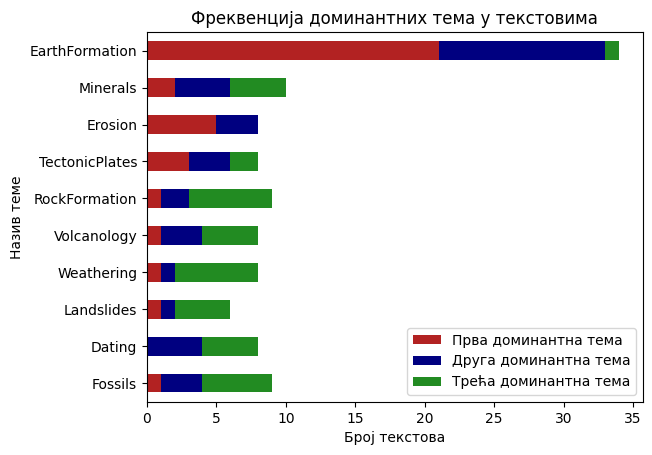

In [45]:
# Visualizing dominant topics in texts 
topic1 = textT10["DominantTopic1"].value_counts() # counting how many times a topic appears as the first dominant
missing_val1 = pd.Series(data = 0, index = ["Dating"]) # because topic Dating does not appear as the first dominant one, we add Dating and value 0 to pd.Series
topic1 = topic1.append(missing_val1) # concatenating the missing topic index and value
topic2 = textT10["DominantTopic2"].value_counts() # counting how many times a topic appears as second dominant 
topic3 = textT10["DominantTopic3"].value_counts() # counting how many times a topic appears as third dominan
missing_val3 = pd.Series(data = 0, index = ["Erosion"]) #because topic Erosion does not appear as the first dominant one, we add Dating and value 0 to pd.Serie
topic3 = topic3.append(missing_val3) # concatenating the missing topic index and value
index = topics

# Crating a df with topic names and freqency
df = pd.DataFrame({"Прва доминантна тема" : topic1, # first dominant topic
                  "Друга доминантна тема" : topic2, # second dominant topic
                  "Трећа доминантна тема" : topic3}, # third dominant topic
                   index = index)
colors = ["firebrick", "navy", "forestgreen"] # setting graph colours

# Creating a bar graph
ax = df.plot(kind = "barh", title = "Фреквенција доминантних тема у текстовима", 
             color = colors, stacked = True)
ax.set_xlabel("Број текстова") # setting X axis name
ax.set_ylabel("Назив теме") # setting Y axis name
ax.invert_yaxis() # sorting values on Y axis from highest to lowest
ax.figure.savefig("DominantTopicsTxt.png") # saving the graph

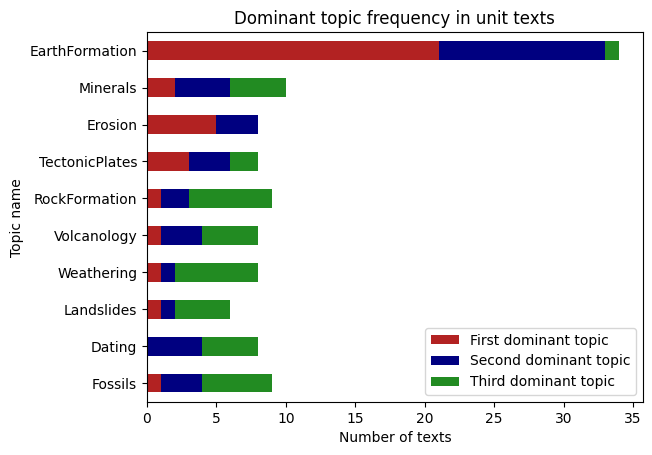

In [46]:
# Localizing the visualization to English
df = pd.DataFrame({"First dominant topic" : topic1,
                  "Second dominant topic" : topic2,
                  "Third dominant topic" : topic3},
                   index = topics)
colors = ["firebrick", "navy", "forestgreen"] 
ax = df.plot(kind = "barh", title = "Dominant topic frequency in unit texts", 
             color = colors, stacked = True)
ax.set_xlabel("Number of texts") 
ax.set_ylabel("Topic name")
ax.invert_yaxis()
ax.figure.savefig("DominantTopicsTxtEngl.png")

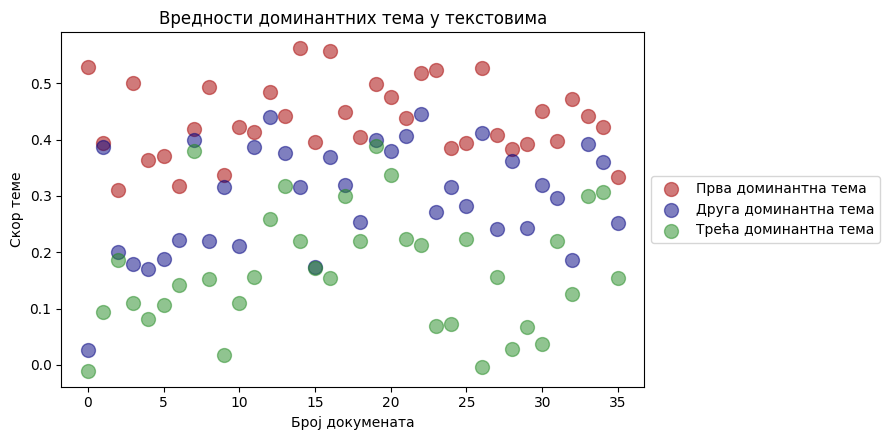

In [47]:
# Visualizing dominant topic values
# source code: 
# https://androidkt.com/multiple-scatter-plots-in-single-plot-in-pandas-using-matplotlib/ 

doc_num = textT10.index # getting dominant topic indexes
legend = ["Прва доминантна тема", "Друга доминантна тема", "Трећа доминантна тема"] # creating a legend for the graph
plt.figure(figsize=(9, 4.5)) # setting figure size
plt.title("Вредности доминантних тема у текстовима") # setting the graph headline
plt.xlabel("Број докумената") # setting X axis name
plt.ylabel("Скор теме") # setting X axis name

# Creating scatter plot
plt.scatter(x = doc_num, y=textT10["MaxValue"], s= 100, c="firebrick", alpha= 0.6) # frist dominant topic values
plt.scatter(x = doc_num, y=textT10["SecondLargest"], s= 100, c="navy", alpha= 0.5) # second dominant topic values
plt.scatter(x=doc_num, y=textT10["ThirdLargest"], s= 100, c="forestgreen", alpha= 0.5) # third dominant topic values
plt.legend(legend, loc= "center left", bbox_to_anchor=(1, 0.5)) # adding a legend

# Saving the figure
ax.figure.savefig("DominantTopicsTxtValues.png")

# Displaying the figure
plt.tight_layout()
plt.show()

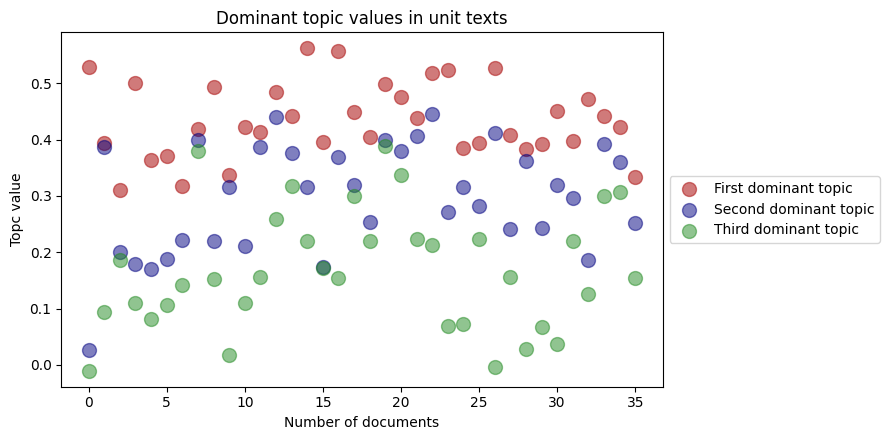

In [48]:
# Localizing the graph to English
doc_num = textT10.index 
legend = ["First dominant topic", "Second dominant topic", "Third dominant topic"] 
plt.figure(figsize=(9, 4.5)) 
plt.title("Dominant topic values in unit texts") 
plt.xlabel("Number of documents") 
plt.ylabel("Topc value") 
plt.scatter(x = doc_num, y=textT10["MaxValue"], s= 100, c="firebrick", alpha= 0.6) 
plt.scatter(x = doc_num, y=textT10["SecondLargest"], s= 100, c="navy", alpha= 0.5) 
plt.scatter(x=doc_num, y=textT10["ThirdLargest"], s= 100, c="forestgreen", alpha= 0.5) 
plt.legend(legend, loc= "center left", bbox_to_anchor=(1, 0.5)) 
ax.figure.savefig("DominantTopicsTxtValuesEngl.png")
plt.tight_layout()
plt.show()


Based on the results, we can conclude that there are often great differences in values of the first and second dominant topic. We believe that the reason behind is is that some topics, such as *EarthFormation*, *Minerals*, and *RockFormation*, contain terms that appear in most of the documents.

In spite of this, we should take all three topics into consideration in our analysis, because, oftentiems, it is the second and/or the third dominant topics that give us more insight in what the text is about. For example, although the row in which the document *fossil formation and palynology* is located lists *EarthFormation* as the dominant topic, the second dominant topic *Fossils* actually tells us more precisely the topic of this document.

### Setting short text TF-IDF parameters

Since we concluded that the previously set parameters of the TF-IDF matrix give good results for the unit texts, but not for the vocabulary and answers, we need to set new parameters for these parts of the data.

When max_df parameter is set to 0.8 and min_df to 3, all terms from some documents are deleted, leaving us with empty documents and unable to assign topics to them, so these parameters are set to 100% and 1. 

Number of features to 700, which is still pretty high compared to short text lenght that is around 50 tokens. We are also defined a new list of stopwords, where we will remove only the indefinite article and the definite article - *a/an* and *the* from the definitions and answers. As in the case of texts, here too we distinguish between engrams and bigrams. 

In [49]:
# Setting TF-IDF parameters for vocabulary and answers
num_features = 700 # broj karakteristika
stop_words_short = ["a", "and", "the"] # creating a shorter stopword list
# Creating a TF-IDF model
vectorizer1 = TfidfVectorizer(max_df = 1.0, min_df = 1, max_features= num_features, stop_words = stop_words_short, ngram_range = (1,2))

### Implementation of LSA to vocabulary

First, we are creating a TF-IDF matrix for definitions from textbook vocabulary in accordance with previosly set parameters. Second, we will apply SVD to the matrix.

In [50]:
# Creating a TF-IDF matrix for definiitons
def_vec = vectorizer1.fit_transform(def_final)

# Applying SVD
lsa_def = svd.fit_transform(def_vec)

# Checking matrix shapes before and after SVD
print(def_vec.shape)
print(lsa_def.shape)


(844, 700)
(844, 10)


In [51]:
# Extracting vocabulary
vocab_dictionary = vectorizer1.get_feature_names_out()

# Showing the frist 100 words and checking the vocabulary legth
print(vocab_dictionary[:100])
print(len(vocab_dictionary))

['ability' 'ability to' 'able' 'about' 'above' 'abrade' 'abrupt'
 'abundant' 'accumulate' 'accumulation' 'achieve' 'achieve something'
 'across' 'act' 'act of' 'action' 'action of' 'action or' 'activity'
 'advance' 'affect' 'after' 'against' 'age' 'aid' 'air' 'all' 'allow'
 'along' 'alongside' 'alter' 'amount' 'amount of' 'an' 'an act'
 'an action' 'an area' 'an igneous' 'an object' 'animal' 'another' 'any'
 'apart' 'appear' 'apply' 'area' 'area where' 'around' 'arrange'
 'artificially' 'as' 'as if' 'as result' 'as to' 'at' 'at same' 'atom'
 'away' 'away from' 'back' 'base' 'base on' 'be' 'be happen' 'be in'
 'be move' 'be not' 'be say' 'be use' 'be very' 'become' 'bedrock'
 'before' 'belong' 'belong to' 'between' 'between two' 'body' 'body of'
 'bottom' 'boundary' 'break' 'bring' 'bring about' 'build' 'but' 'by'
 'can' 'can be' 'carbon' 'carry' 'category' 'cause' 'cause by'
 'cause something' 'cell' 'certain' 'certain quality' 'certain way'
 'chain']
700


In [52]:
# Checking matrix dimensions obtained by SVD
Sigma_def = svd.singular_values_ 
V_transpose_def = svd.components_.T
print(Sigma_def.shape)
print(V_transpose_def.shape)

(10,)
(700, 10)


After applying SVD to TF-IDF matrix, we got 844 definitons distributed among 10 topics. In this case, the definitions are our documents. Also, we got 700 terms with highest weights that describe each of the topics.

In [53]:
# Extracting and showing 15 terms with the heighest weights for each topic
top_words(svd, vocab_dictionary)

Topic 0:  ['something', 'of', 'use', 'that', 'to', 'or', 'for', 'be', 'describe', 'use for', 'for describe', 'an', 'something that', 'describe something', 'in']
Topic 1:  ['describe', 'for describe', 'use for', 'describe something', 'for', 'use', 'something that', 'that', 'that be', 'be', 'lack', 'that have', 'not', 'describe that', 'happen']
Topic 2:  ['to', 'refer', 'refer to', 'be', 'to something', 'that', 'rock', 'in', 'that be', 'which', 'mineral', 'something that', 'or', 'water', 'process']
Topic 3:  ['act', 'act of', 'an act', 'of', 'something', 'use for', 'use', 'for describe', 'for', 'describe', 'describe something', 'determine', 'of something', 'or someone', 'something or']
Topic 4:  ['refer to', 'refer', 'something', 'to something', 'to', 'something that', 'act of', 'act', 'an act', 'something to', 'that be', 'someone', 'action', 'or someone', 'something or']
Topic 5:  ['be', 'that be', 'that', 'something that', 'act of', 'of', 'act', 'rock', 'action of', 'it', 'action', 'fr

As we can see, terms with the heighest weights for definitions are significantly different from the terms in the texts, and we can especially notice this in a frequent use of verbs such as `act, happen, use, refer` and indefinite noun pronouns `something`. However, domain words such as `rock, crystal, sedimentary, igneous` etc. also appear.

Next, we will create a dataframe `lsa_u_def`, from which we will obtain dominant topics for each definiton by using the `dominant_topics` function.

In [54]:
# Crating a document-topic df
lsa_u_def = pd.DataFrame(lsa_def, columns = topics)
terms_list = sorted(list(set(terms_clean1))) # extracting unique terms to a list

# Applying dominant_topics funtion to definitons df
lsa_u_def = dominant_topics(lsa_u_def)
lsa_u_def.insert(0, "Term", terms_list) # adding a column with term lemmas
lsa_u_def.insert(1, "Unit", vocab1.Unit) # adding a column with the number of the unit in which the term is defined
lsa_u_def.insert(2, "Definition", def_final) # adding a column with lemmatized definitions

# Showing frist five rows of the df
lsa_u_def.head()

,Term,Unit,Definition,EarthFormation,Minerals,Erosion,TectonicPlates,RockFormation,Volcanology,Weathering,Landslides,Dating,Fossils,MaxValue,SecondLargest,ThirdLargest,DominantTopic1,DominantTopic2,DominantTopic3
0,abiotic,Unit 1,abiotic use for describe something occur in na...,0.459889,0.382142,-0.071308,0.014744,-0.078882,0.079458,-0.102777,0.044632,-0.065299,-0.028499,0.459889,0.382142,0.079458,EarthFormation,Minerals,Volcanology
1,abnormal,Unit 1,abnormal use for describe something differ fro...,0.382893,0.286422,-0.141555,0.085859,-0.093161,-0.110849,-0.065983,0.044551,-0.071124,-0.014414,0.382893,0.286422,0.085859,EarthFormation,Minerals,TectonicPlates
2,above mention,Unit 1,above mention use for refer to something previ...,0.215962,0.068776,0.126202,-0.088584,0.142762,-0.011426,0.040101,0.021230,-0.049102,0.052369,0.215962,0.142762,0.126202,EarthFormation,RockFormation,Erosion
3,abrade,Unit 1,abrade an action of wear away or rub off somet...,0.220333,-0.240422,-0.092054,0.063261,0.017350,0.056752,0.065594,0.009828,0.046711,0.084583,0.220333,0.084583,0.065594,EarthFormation,Fossils,Weathering
4,abrupt,Unit 1,abrupt refer to something that bring about sud...,0.311149,-0.072526,0.175730,-0.193023,0.293077,-0.005066,0.146780,0.004075,-0.101092,0.044393,0.311149,0.293077,0.175730,EarthFormation,RockFormation,Erosion


In [55]:
# Descriptive statistics for topics in vocabulary definitions
display(lsa_u_def[["EarthFormation",	"Minerals",	"Erosion",	"TectonicPlates",	"RockFormation",	"Volcanology",	"Weathering",	"Landslides",	"Dating",	"Fossils"]].describe())

,EarthFormation,Minerals,Erosion,TectonicPlates,RockFormation,Volcanology,Weathering,Landslides,Dating,Fossils
count,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000
mean,0.203587,-0.045014,0.021769,0.000446,-0.023428,-0.005086,0.001441,-0.001617,0.000034,0.004734
std,0.108174,0.167886,0.133991,0.127644,0.122475,0.100414,0.096633,0.095512,0.093409,0.092529
min,0.022233,-0.458963,-0.453733,-0.314525,-0.358003,-0.399959,-0.362339,-0.347768,-0.254324,-0.258647
25%,0.123381,-0.130362,-0.050746,-0.056135,-0.102885,-0.064694,-0.051582,-0.050319,-0.058275,-0.045688
50%,0.179542,-0.061285,0.047090,-0.007061,-0.026991,0.002405,0.003786,-0.006108,-0.004363,-0.000373
75%,0.261571,-0.004940,0.099998,0.026969,0.039791,0.061060,0.052937,0.039557,0.052046,0.048256
max,0.686236,0.618423,0.482266,0.703326,0.481329,0.406296,0.525400,0.453154,0.378232,0.431153


In [56]:
# Saving the reults as a .csv file
lsa_u_def.to_csv("RaspodelaVokabularaPoTemama.csv", index = False)

In the new data frame, `defT10`, we added a column with terms (`Term`), units in which the term is located (`Unit`) and the text of the definition (`Definition`), while the names of the other columns previously assigned topic names are preserved in the `topic` variable.

In [57]:
# Extracting term categories for each term from the vocabulary df
cat = vocab1["Category"].tolist()

# Creating a dictionary where term is the key, and value is a category to which the term belongs
# categories are - academic, geological, mineral
cat_dict = {terms_clean[i] : cat[i] for i in range(len(terms_clean))}

# We do not want to display the entire ditionary, so we will first split it
# source: https://stackoverflow.com/questions/7971618/return-first-n-keyvalue-pairs-from-dict 
# Importing libraries
from itertools import islice

def take(n, iterable):
    # Return the first n items of the iterable as a list
    return list(islice(iterable, n))

# Stampamo recnik i proveravamo duzinu liste
n_items = take(20, cat_dict.items())
print(n_items)
print(len(cat_dict))

[('accretion', 'academic'), ('affect', 'academic'), ('alongside', 'academic'), ('although', 'academic'), ('apatite', 'mineral'), ('apply', 'academic'), ('arrange', 'academic'), ('asbestos', 'mineral'), ('atmosphere', 'geological'), ('believe', 'academic'), ('beryl', 'mineral'), ('biosphere', 'geological'), ('bond', 'geological'), ('brittle', 'academic'), ('build up', 'academic'), ('capacity', 'academic'), ('chondrite', 'geological'), ('classify', 'academic'), ('clay', 'mineral'), ('cleavage', 'geological')]
844


As the topics refer to the fields of geology, and our vocabulary consists of words that are geological terms, but also from general vocabulary, special attention should be paid to the classification of words that belong to general vocabulary into topics.

In [58]:
# Extracting dominant topics to a new df
defT10 = pd.DataFrame({
                       "Term": terms_list,   # adding a column with term lemmas
                       "Definition": sorted(list(def_final)), # adding a column with lemmatized definitions
                       "Category": list(cat_dict.values()), # a column with term category
                       "MaxValue": lsa_u_def.MaxValue, # first dominant topic value
                       "SecondLargest": lsa_u_def.SecondLargest, # second dominant topic value
                       "ThirdLargest": lsa_u_def.ThirdLargest, # third dominant topic value
                       "DominantTopic1": lsa_u_def.DominantTopic1, # first dominant topic name
                       "DominantTopic2": lsa_u_def.DominantTopic2, # second dominant topic name
                       "DominantTopic3": lsa_u_def.DominantTopic3}) # third dominant topic name
defT10 # displaying the dataframe

,Term,Definition,Category,MaxValue,SecondLargest,ThirdLargest,DominantTopic1,DominantTopic2,DominantTopic3
0,abiotic,abiotic use for describe something occur in na...,academic,0.459889,0.382142,0.079458,EarthFormation,Minerals,Volcanology
1,abnormal,abnormal use for describe something differ fro...,academic,0.382893,0.286422,0.085859,EarthFormation,Minerals,TectonicPlates
2,above mention,above mention use for refer to something previ...,academic,0.215962,0.142762,0.126202,EarthFormation,RockFormation,Erosion
3,abrade,abrade an action of wear away or rub off somet...,academic,0.220333,0.084583,0.065594,EarthFormation,Fossils,Weathering
4,abrupt,abrupt refer to something that bring about sud...,mineral,0.311149,0.293077,0.175730,EarthFormation,RockFormation,Erosion
...,...,...,...,...,...,...,...,...,...
839,wolframite,wolframite a grayish or brownish mineral occur...,academic,0.159258,0.119586,0.007642,EarthFormation,Erosion,Fossils
840,worldwide,worldwide use for describe something happen or...,academic,0.380335,0.301335,0.127217,EarthFormation,Minerals,Fossils
841,xenolith,xenolith an inclusion or a piece of rock embed...,geological,0.163365,0.116452,0.063244,EarthFormation,Weathering,Erosion
842,yield,yield an act of produce something generate mak...,academic,0.446513,0.236741,0.180454,TectonicPlates,EarthFormation,RockFormation


In [59]:
# Saving the dataframe as a .cvs file
defT10.to_csv("DominantTopicsDef.csv", index = False)

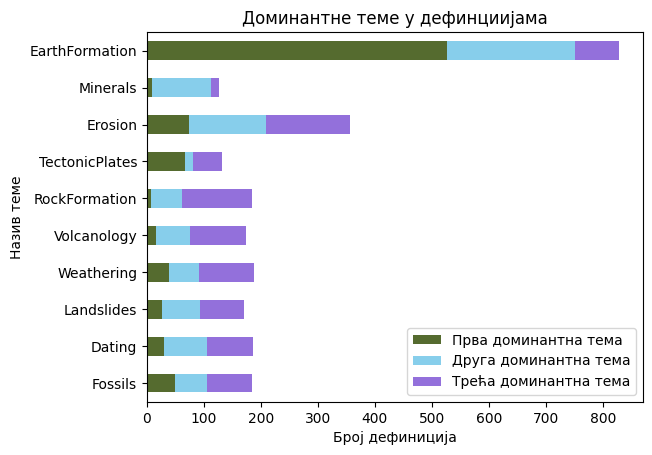

In [60]:
# Visualizing dominant topics in vocabulary definitions
topic1 = defT10["DominantTopic1"].value_counts() # counting how many times a topic appears as the first dominant
topic2 = defT10["DominantTopic2"].value_counts() # counting how many times a topic appears as the second dominant
topic3 = defT10["DominantTopic3"].value_counts() # counting how many times a topic appears as the third dominant
index = topics 

# Crating a df with topic names and freqency
df = pd.DataFrame({"Прва доминантна тема" : topic1, # first dominant topic
                  "Друга доминантна тема" : topic2, # second dominant topic
                  "Трећа доминантна тема" : topic3}, # third dominant topic
                   index = index) # setting index

# # Creating a bar graph
colors = ["darkolivegreen", "skyblue", "mediumpurple"] # setting graph colours
ax = df.plot(kind = "barh", title = "Доминантне теме у дефинциијама", 
             color = colors, stacked = True)
ax.set_xlabel("Број дефиниција") # setting X axis name
ax.set_ylabel("Назив теме") # setting Y axis name
ax.invert_yaxis() # sorting values on Y axis from highest to lowest
ax.figure.savefig("DominantTopicsDef.png") # saving the graph

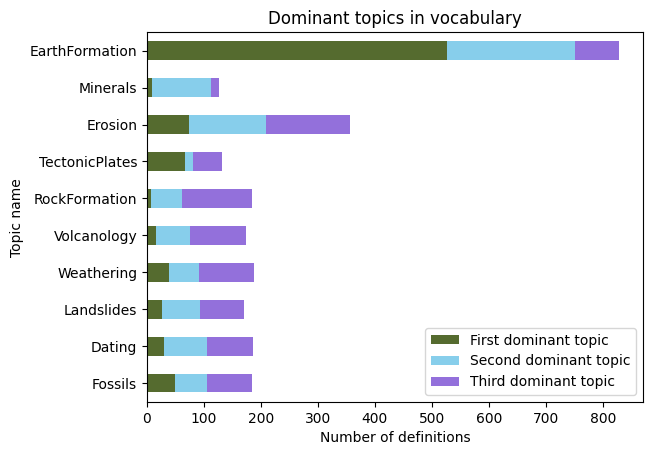

In [61]:
# Localizing the graph to English
topic1 = defT10["DominantTopic1"].value_counts() 
topic2 = defT10["DominantTopic2"].value_counts() 
topic3 = defT10["DominantTopic3"].value_counts() 
index = topics 
df = pd.DataFrame({"First dominant topic" : topic1,
                  "Second dominant topic" : topic2,
                  "Third dominant topic" : topic3},
                   index = index)
colors = ["darkolivegreen", "skyblue", "mediumpurple"] 
ax = df.plot(kind = "barh", title = "Dominant topics in vocabulary", 
             color = colors, stacked = True)
ax.set_xlabel("Number of definitions") 
ax.set_ylabel("Topic name") 
ax.invert_yaxis() 
ax.figure.savefig("DominantTopicsDefEngl.png")

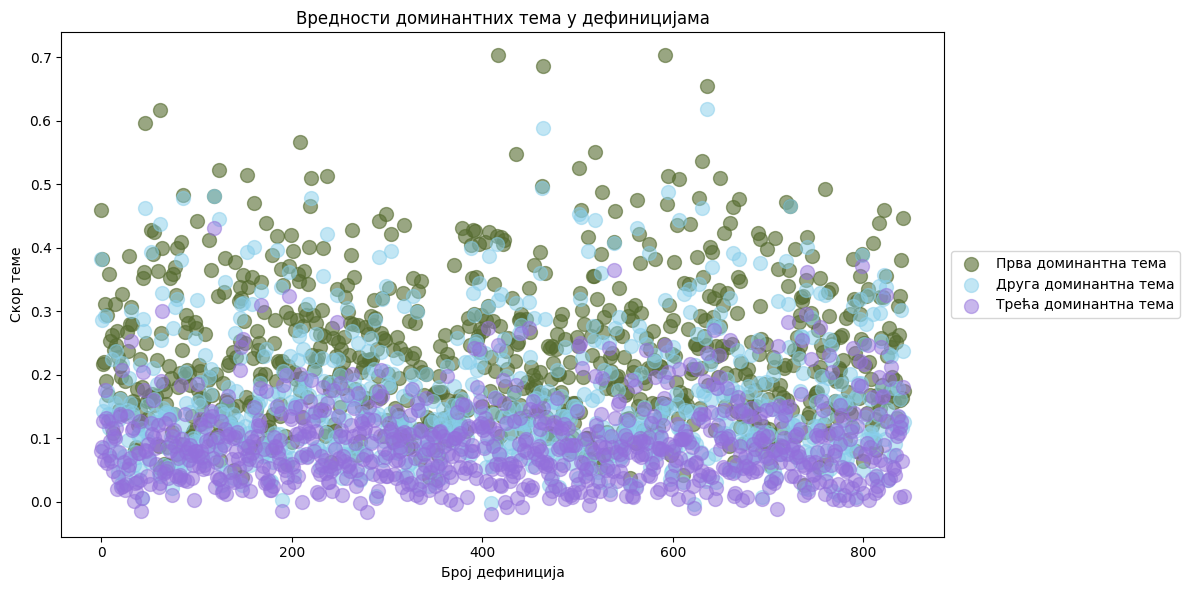

In [62]:
# Visualizing dominant topics values in definitions
doc_num = defT10.index # getting dominant topic indexes
legend = ["Прва доминантна тема", "Друга доминантна тема", "Трећа доминантна тема"] # creating a legend for the graph
plt.figure(figsize=(12, 6)) # setting figure size
plt.title("Вредности доминантних тема у дефиницијама")  # setting the graph headline
plt.xlabel("Број дефиниција") # setting X axis name
plt.ylabel("Скор теме") # setting Y axis name

# Pravimo dijagram rasejanja
plt.scatter(x = doc_num, y= defT10["MaxValue"], s= 100, c= "darkolivegreen", alpha= 0.6) # frist dominant topic values
plt.scatter(x = doc_num, y= defT10["SecondLargest"], s= 100, c= "skyblue", alpha= 0.5) # second dominant topic values
plt.scatter(x=doc_num, y= defT10["ThirdLargest"], s= 100, c= "mediumpurple", alpha= 0.5) # third dominant topic values
plt.legend(legend, loc= "center left", bbox_to_anchor=(1, 0.5)) # adding a legend
# Displaying the figure
plt.tight_layout()
ax.figure.savefig("DominantTopicsDefValues.png") # Saving the figure
plt.show()

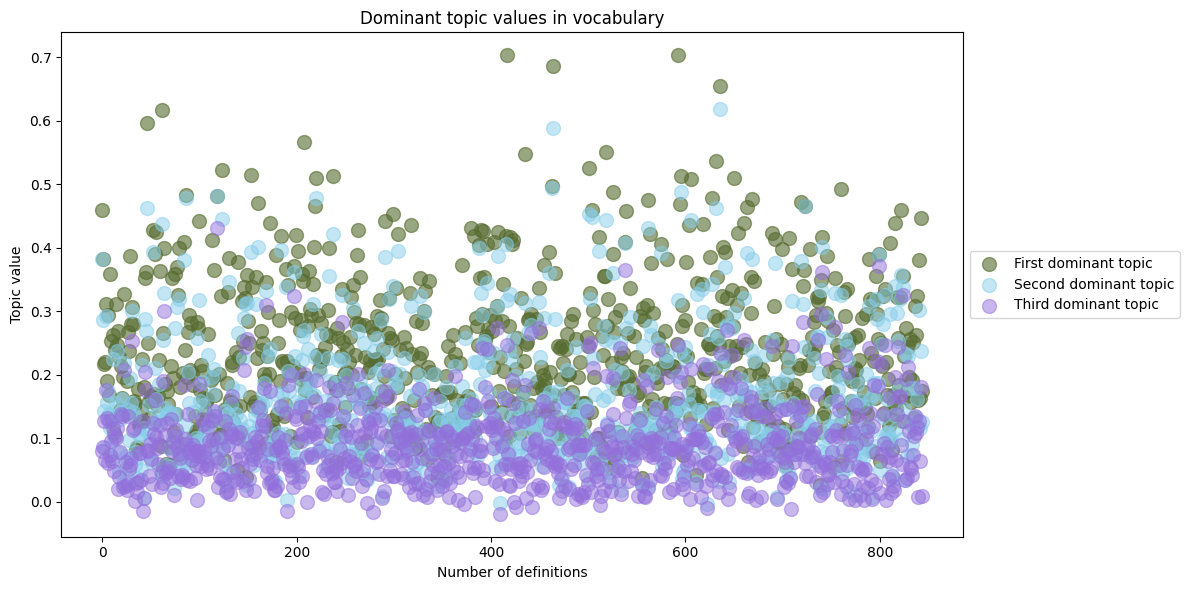

In [63]:
# Localizing the graph to English
doc_num = defT10.index 
legend = ["First dominant topic", "Second dominant topic", "Third dominant topic"] 
plt.figure(figsize=(12, 6)) 
plt.title("Dominant topic values in vocabulary") 
plt.xlabel("Number of definitions") 
plt.ylabel("Topic value") 
plt.scatter(x = doc_num, y= defT10["MaxValue"], s= 100, c= "darkolivegreen", alpha= 0.6) 
plt.scatter(x = doc_num, y= defT10["SecondLargest"], s= 100, c= "skyblue", alpha= 0.5) 
plt.scatter(x=doc_num, y= defT10["ThirdLargest"], s= 100, c= "mediumpurple", alpha= 0.5) 
plt.legend(legend, loc= "center left", bbox_to_anchor=(1, 0.5)) 
plt.tight_layout()
ax.figure.savefig("DominantTopicsDefValuesEngl.png")
plt.show()

For vocabulary, we also identified three dominant topics for each document. The differences in the values of the dominant topics are somewhat smaller than in texts, with words belonging to the general vocabulary having relatively small values for the second and third dominant topic.

As we can see, EathFormation is most frequent as the first dominant topic, while Minerals is the least represented. As the third dominant topic, almost all topic appear equally.

When it comes to the values of the dominant themes, we see the values of the first dominant topic are most scattered, ranging from over 0.7 to below 0.1. The values of the second dominant topic are slightly lower than the first, but equally scattered, while the values of the third dominant theme are for the most part low, below 0.4, and relatively homogeneous.

### Implementation of LSA to participant answers

Lastly, we are applying LSA to participant answers. First, we will create a TF-IDF matrix from participant answers, and save it to `answ_vec` variable. Then, we will apply SVD to the obtained matrix. As in definitions, we are keeping values of 1 for the `max_df` and `min_df` TF-IDF parametars.

In [64]:
# Creating a TF-IDF matrix for participant answers
answ_vec = vectorizer1.fit_transform(answ_clean)

# Applying SVD
lsa_answ = svd.fit_transform(answ_vec)

# Checking matrix shape before and after SVD
print(answ_vec.shape)
print(lsa_answ.shape)

(72, 700)
(72, 10)


Dobili smo TF-IDF matricu sa 72 dokumenta (odgovora ispitanika) i 700 termina. Nakon primene SVD na dobijenu matricu, 72 odgovora i 700 termina raspoređeno je u 10 tema.

In [65]:
# Getting a dictionary based on TF-IDF
answ_dictionary = vectorizer1.get_feature_names_out()

# Showing the frist 100 terms in the dictionary and checking dictionary length
print(answ_dictionary[:100])
print(len(answ_dictionary))

['abnormally' 'action' 'action of' 'activity' 'air' 'amount' 'amount of'
 'an' 'an action' 'an area' 'area' 'area more' 'as' 'as lithification'
 'as starting' 'at' 'at convergent' 'at distance' 'atmosphere'
 'atmosphere absorb' 'atmosphere back' 'atmosphere increase'
 'atmosphere trap' 'average' 'average temperature' 'back' 'be'
 'be current' 'be form' 'be process' 'blend' 'break' 'burn' 'by' 'can'
 'can be' 'carbon' 'carbon dioxide' 'carry' 'carry particle'
 'catastrophic' 'cause' 'cause by' 'cause mainly' 'cause planet' 'cave'
 'cave or' 'cement' 'cement form' 'cementation' 'cementation through'
 'century' 'century in' 'certain' 'certain factor' 'change' 'change less'
 'change particular' 'characteristic' 'characteristic chemical'
 'characteristic of' 'check' 'check previous' 'chemical'
 'chemical composition' 'chemical reaction' 'clastic'
 'clastic sedimentary' 'clay' 'clay to' 'climate' 'climate change' 'cloud'
 'cloud precipitate' 'co' 'co other' 'coal' 'coal oil' 'collect'
 'coll

In [66]:
# Checking SVD matricies dimensions
Sigma_answ = svd.singular_values_ 
V_transpose_answ= svd.components_.T
print(Sigma_answ.shape)
print(V_transpose_answ.shape)

(10,)
(700, 10)


In [67]:
# Extracting 15 terms with highest weights for each topic
top_words(svd, answ_dictionary)

Topic 0:  ['be', 'of', 'in', 'to', 'or', 'earth', 'rock', 'water', 'process', 'form', 'by', 'surface', 'an', 'something', 'of earth']
Topic 1:  ['an', 'make', 'area more', 'make an', 'more urban', 'urban', 'an area', 'more', 'area', 'to', 'be process', 'process of', 'of make', 'process', 'something']
Topic 2:  ['more', 'area more', 'make an', 'more urban', 'urban', 'an area', 'area', 'an', 'make', 'be', 'in', 'of make', 'soil', 'space in', 'line']
Topic 3:  ['use', 'use for', 'for', 'move towards', 'towards', 'move', 'series', 'towards series', 'on', 'point', 'mean', 'be', 'one', 'one point', 'tendency']
Topic 4:  ['mean', 'something', 'mean that', 'that something', 'that', 'on something', 'soil', 'in', 'to give', 'to something', 'rely', 'rely on', 'to rely', 'to', 'on']
Topic 5:  ['supply', 'be', 'short', 'short supply', 'mean', 'meteorite', 'stony', 'stony meteorite', 'verb', 'of', 'of water', 'shortage', 'shortage of', 'or', 'that']
Topic 6:  ['supply', 'short', 'short supply', 'of 

As shown above, terms with the heighest weights for each topic in participant answeres are closer to terms extracted from the vocabulary than to those extracted from unit texts. This is expected, since both vocabulary and answers have a form of a definition.

So here, we can also see terms such as `something`, `keep something`, `action`, `action keep`, `action thing`, that are frequently used in defining words. Also, we can spot terms pertaining to geology, e.g. `earth`, `land`, `earth surface`, `rock`, `erosion` etc, which could help in assigning topics to answers defining geological notions.

After SVD, we will make a lsa_qa dataframe showing topics and their respective values for all answers. To this dataframe, we will apply the `dominant_topics` function in order to obtain most dominant topics in participant answers

In [68]:
# Creating a dataframe containing all answers and topics with their values for each answer
lsa_qa = pd.DataFrame(lsa_answ.round(decimals = 4), columns = topics)


# Extracting dominant topics
lsa_qa = dominant_topics(lsa_qa)
lsa_qa.insert(0, "Question", q_clean) # adding a column with questions lemmas
lsa_qa.insert(1, "Answer", answ_clean) # adding a column with lemmatized answers

lsa_qa.sort_values(by = "Question", inplace = True) # sorting values A-Z by quesiton lemmas
lsa_qa.reset_index(drop = True, inplace = True) # reseting index
lsa_qa.head() # showing first 5 rows of the df

,Question,Answer,EarthFormation,Minerals,Erosion,TectonicPlates,RockFormation,Volcanology,Weathering,Landslides,Dating,Fossils,MaxValue,SecondLargest,ThirdLargest,DominantTopic1,DominantTopic2,DominantTopic3
0,backlash,adverse reaction to a recent development,0.0719,0.0407,-0.1594,-0.0518,0.0366,-0.0409,0.0769,0.0508,0.1344,-0.0269,0.1344,0.0769,0.0719,Dating,Weathering,EarthFormation
1,cataclysmic,catastrophic,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,EarthFormation,EarthFormation,EarthFormation
2,cataclysmic,be use for destruction on a large scale,0.1380,0.0444,-0.0078,0.5384,-0.0954,-0.1909,0.0435,-0.0390,0.0888,-0.0537,0.5384,0.1380,0.0888,TectonicPlates,EarthFormation,Dating
3,cavity,be open space in a limestone cave or in coal,0.2955,-0.3266,0.1828,-0.0242,0.0788,-0.0709,0.0203,-0.0729,0.0878,-0.1536,0.2955,0.1828,0.0878,EarthFormation,Erosion,Dating
4,chemical weathering,erosion or disintegration of rock cause by che...,0.2024,-0.0138,-0.0262,0.0084,-0.0384,0.0504,-0.0363,0.3581,-0.1170,-0.0553,0.3581,0.2024,0.0504,Landslides,EarthFormation,Volcanology


In [69]:
# Descriptive statistics of topics in participant answers
display(lsa_qa[["EarthFormation",	"Minerals",	"Erosion",	"TectonicPlates",	"RockFormation",	"Volcanology",	"Weathering",	"Landslides",	"Dating",	"Fossils"]].describe())

,EarthFormation,Minerals,Erosion,TectonicPlates,RockFormation,Volcanology,Weathering,Landslides,Dating,Fossils
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.178803,0.009775,-0.004872,0.022993,0.015878,-0.001260,0.011308,0.003133,0.020142,0.000042
std,0.112248,0.165837,0.163984,0.156464,0.154793,0.154715,0.149353,0.147231,0.142498,0.141845
min,-0.000000,-0.579100,-0.424600,-0.199100,-0.221900,-0.371000,-0.225400,-0.276300,-0.287400,-0.402400
25%,0.099625,-0.040300,-0.117025,-0.051050,-0.082950,-0.071150,-0.085350,-0.075100,-0.073425,-0.073350
50%,0.161650,0.002700,-0.000000,0.000000,-0.002600,-0.000000,-0.000300,-0.004700,-0.005450,-0.000000
75%,0.257950,0.058900,0.069600,0.054175,0.058775,0.082325,0.073450,0.068100,0.088050,0.028775
max,0.430600,0.603200,0.568700,0.699800,0.628700,0.380500,0.543100,0.359700,0.489900,0.578100


In [70]:
# Saving the dataframe as a .csv file
lsa_qa.to_csv("RaspodelaOdgovoraPoTemama.csv", index = False)

Lastly, we are creating a dataframe containing dominant topics and their values, along with quesitons lemmas and lemmatized answers.

In [71]:
# Creating a dataframe with most dominant topics in participant answers

qaT10 = pd.DataFrame({
                       "Question": q_clean, # adding a column with question lemmas
                       "Answer": answ_clean, # adding a column with lemmatized answers
                       "MaxValue": lsa_qa.MaxValue, # first dominant topic value
                       "SecondLargest": lsa_qa.SecondLargest, # second dominant topic value
                       "ThirdLargest": lsa_qa.ThirdLargest, # third dominant topic value
                       "DominantTopic1": lsa_qa.DominantTopic1, # first dominant topic name
                       "DominantTopic2": lsa_qa.DominantTopic2, # second dominant topic name
                       "DominantTopic3": lsa_qa.DominantTopic3}) # third dominant topic name
qaT10 # displaying the dataframe

,Question,Answer,MaxValue,SecondLargest,ThirdLargest,DominantTopic1,DominantTopic2,DominantTopic3
0,unconsolidated,incoherent loose unstratified,0.1344,0.0769,0.0719,Dating,Weathering,EarthFormation
1,backlash,adverse reaction to a recent development,-0.0000,-0.0000,-0.0000,EarthFormation,EarthFormation,EarthFormation
2,chemical weathering,erosion or disintegration of rock cause by che...,0.5384,0.1380,0.0888,TectonicPlates,EarthFormation,Dating
3,malleability,alter or shape by external force,0.2955,0.1828,0.0878,EarthFormation,Erosion,Dating
4,transpire,release liquid through opening in leave of a p...,0.3581,0.2024,0.0504,Landslides,EarthFormation,Volcanology
...,...,...,...,...,...,...,...,...
67,yield,yield mean income,0.0000,-0.0000,-0.0000,EarthFormation,EarthFormation,EarthFormation
68,seafloor,the seabed be the bottom of the ocean or the t...,0.0444,0.0134,0.0112,Landslides,EarthFormation,Volcanology
69,seafloor,the seafloor be the ground under the sea,0.6032,0.5687,0.3052,Minerals,Erosion,EarthFormation
70,remote sensing,remote sensing be the process of detect and mo...,0.5980,0.5655,0.1742,Minerals,Erosion,EarthFormation


In [72]:
# Saving the dataframe as a .csv file
qaT10.to_csv("DominantTopicsQA.csv", index = False)

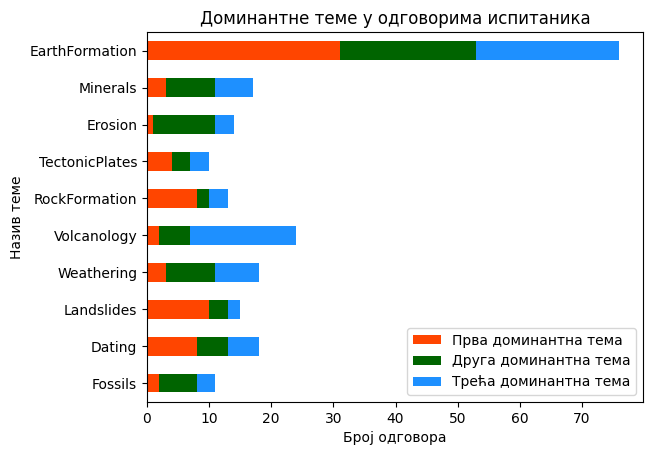

In [73]:
# Visualizing dominant topics in vocabulary definitions
topic1 = qaT10["DominantTopic1"].value_counts() # counting how many times a topic appears as the first dominant
topic2 = qaT10["DominantTopic2"].value_counts() # counting how many times a topic appears as the second dominant
topic3 = qaT10["DominantTopic3"].value_counts() # counting how many times a topic appears as the third dominant
index = topics # setting index

# Pravimo okvir podataka sa nazivima tema i brojem njihovog javljanja u prve tri dominantne teme
df = pd.DataFrame({"Прва доминантна тема" : topic1, # first dominant topic
                  "Друга доминантна тема" : topic2, # second dominant topic
                  "Трећа доминантна тема" : topic3}, # third dominant topic
                   index = index)
colors = ["orangered", "darkgreen", "dodgerblue"] # podesavamo boje za vizalizaciju

# Creating a horizontal bar graph
ax = df.plot(kind = "barh", title = "Доминантне теме у одговорима испитаника", #setting graph colours
             color = colors, stacked = True)
ax.set_xlabel("Број одговора") # setting X axis name
ax.set_ylabel("Назив теме") # setting Y axis name
ax.invert_yaxis() # sorting values on Y axis from highest to lowest
ax.figure.savefig("DominantTopicsAnsw.png") # saving the graph

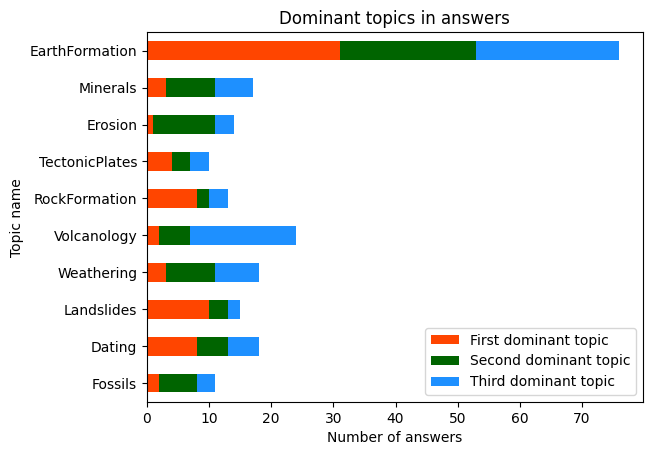

In [74]:
# Localizing to English
df = pd.DataFrame({"First dominant topic" : topic1,
                  "Second dominant topic" : topic2,
                  "Third dominant topic" : topic3},
                   index = topics)
colors = ["orangered", "darkgreen", "dodgerblue"] 


ax = df.plot(kind = "barh", title = "Dominant topics in answers", 
             color = colors, stacked = True)
ax.set_xlabel("Number of answers") 
ax.set_ylabel("Topic name")
ax.invert_yaxis() 
ax.figure.savefig("DominantTopicsAnswEngl.png")

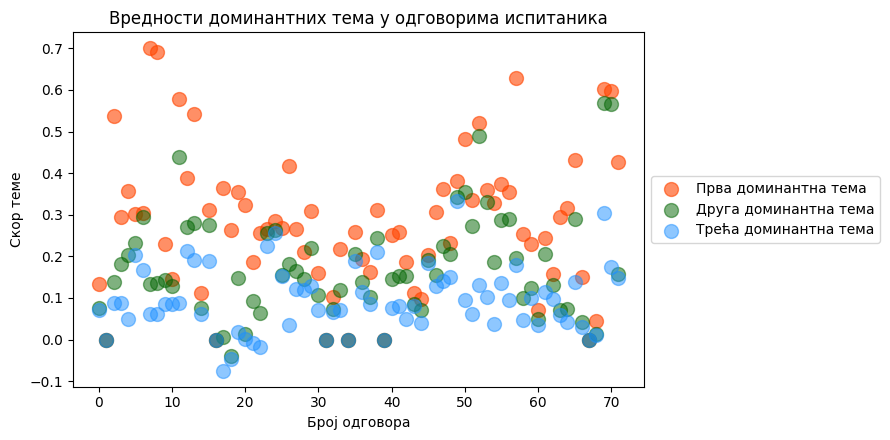

In [75]:
# Visualizing dominant topics values in definitions
doc_num = qaT10.index # getting dominant topic indexes
legend = ["Прва доминантна тема", "Друга доминантна тема", "Трећа доминантна тема"] # creating a legend for the graph
plt.figure(figsize=(9, 4.5)) # setting figure size
plt.title("Вредности доминантних тема у одговорима испитаника") # setting the graph headline
plt.xlabel("Број одговора") # setting X axis name
plt.ylabel("Скор теме") # setting Y axis name

# Pravimo dijagram rasejanja
plt.scatter(x = doc_num, y= qaT10["MaxValue"], s= 100, c= "orangered", alpha= 0.6) # frist dominant topic values
plt.scatter(x = doc_num, y= qaT10["SecondLargest"], s= 100, c= "darkgreen", alpha= 0.5) # second dominant topic values
plt.scatter(x=doc_num, y= qaT10["ThirdLargest"], s= 100, c= "dodgerblue", alpha= 0.5) # second dominant topic values
plt.legend(legend, loc= "center left", bbox_to_anchor=(1, 0.5)) # adding a legend
# Displaying the figure
plt.tight_layout()
ax.figure.savefig("DominantTopicsAnswValues.png")  # Saving the figure
plt.show()

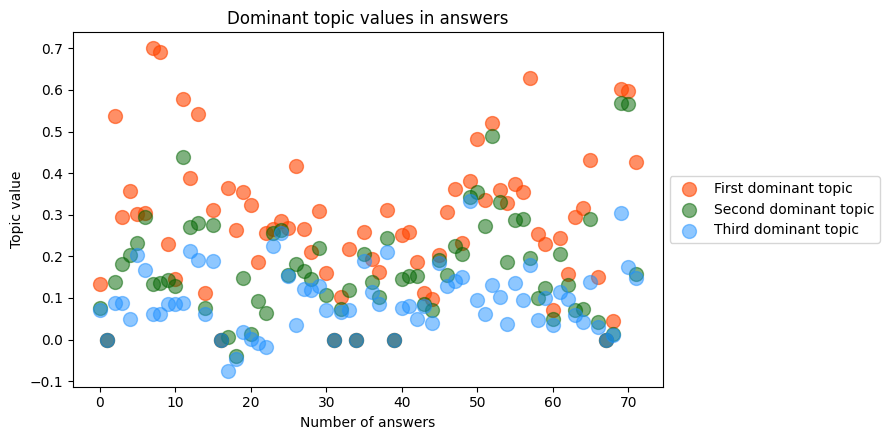

In [76]:
# localizing to English
doc_num = qaT10.index 
legend = ["First dominant topic", "Second dominant topic", "Third dominant topic"] 
plt.figure(figsize=(9, 4.5)) 
plt.title("Dominant topic values in answers") 
plt.xlabel("Number of answers")
plt.ylabel("Topic value")

plt.scatter(x = doc_num, y= qaT10["MaxValue"], s= 100, c= "orangered", alpha= 0.6) 
plt.scatter(x = doc_num, y= qaT10["SecondLargest"], s= 100, c= "darkgreen", alpha= 0.5) 
plt.scatter(x=doc_num, y= qaT10["ThirdLargest"], s= 100, c= "dodgerblue", alpha= 0.5) 
plt.legend(legend, loc= "center left", bbox_to_anchor=(1, 0.5)) 

plt.tight_layout()
ax.figure.savefig("DominantTopicsAnswValues.png")
plt.show()

In participan answers answers, topic EearthFormation is the most frequent one as the first, second and third dominant topic. Erosion is the least frequent as the fist dominant, wile as the second dominant, it closely follows EarthFormation. The least represented topics in the answers are Fossils and RockFormation.

The values of the first dominant topic are quite scattered, ranging from 0.7 to almost 0.0. The difference in the values of the first dominant topic are significantly greater than values of the second and third dominant topic than they were in texts and definitions. This is not unexpected, considering that we have several answers to the same question, so some topics are repeated more. The second dominant topic values range from around 0.5 to around 0.1, while the third dominant topic is in some cases below 0.0, that is, it is negative.

# Measuring cosine similarity

In this section, we will first compute similarity between all unit text with an aim to find the most similar ones. Then, we will compute similarty between a topic vector of an answer A and: a) topic vector of the text in which the word defined in the answer is used; b) topic vector of the correct answer (golden standard); c) topic vector of the most similar answer B to the target answer A.

For measuring cosine similarity, we used the SciKit-Learn library and called the `cosine_similarity` function. More about computing text simiarity can be found at: 
1. https://github.com/MrFuguDataScience/MLE_Basics_N_Stats/blob/master/cosine_similar_dtaMine.ipynb 
2. https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/ 

### Finding most similar unit texts

First, we will measure cosine similarity between all unit texts in order to find the most similar ones.

In [77]:
# Importing funtions and libraries
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Dropping columns not containing topic values
texts_u1 = texts_u.drop(columns = ["TextHedline", "MaxValue", "SecondLargest", "ThirdLargest", "DominantTopic1", "DominantTopic2", "DominantTopic3"])

# Measuring cosine similarity between unit texts
texts_cos = pd.DataFrame(cosine_similarity(texts_u1, dense_output = True))
texts_cos.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.000000,0.645162,0.615454,0.557942,0.618669,0.678440,0.638265,0.297256,0.630792,0.457469,...,0.583735,0.406557,0.217157,0.627137,0.209823,0.137817,0.592211,0.199852,0.154902,0.729859
1,0.645162,1.000000,0.878346,0.102784,0.026733,0.050943,0.088857,-0.017947,0.301300,0.048419,...,0.785348,0.258793,0.223244,0.758032,0.174818,0.049584,0.186803,0.203456,0.131225,0.448645
2,0.615454,0.878346,1.000000,0.256831,0.056890,0.029590,0.281800,0.226714,0.549252,-0.035651,...,0.579842,0.326812,0.138215,0.544852,0.057390,0.001634,0.239904,0.325238,0.258283,0.536732
3,0.557942,0.102784,0.256831,1.000000,0.819054,0.740432,0.485527,0.561209,0.836249,0.272541,...,0.357551,0.265624,0.369743,0.183762,0.230724,0.224597,0.342958,0.188646,0.180622,0.263016
4,0.618669,0.026733,0.056890,0.819054,1.000000,0.978635,0.399043,0.162812,0.556939,0.358546,...,0.155092,0.051263,0.138012,0.090128,0.132852,0.055877,0.275681,0.026609,0.049843,0.222903


In [78]:
# Saving the dataframe as a .cvs file
texts_cos.to_csv("TextsCOS.csv")

Because our aim is to find the most similar texts, we need to adjust the obtained results. Since the similarity of each text with itself is 1 (cos(T0, T0) = 1), if we would proceed to finding highest values for each row, we would just get this value of 1. Therefore, we are replacing text simiartiy with itself for 0 with our `one_to_zero` funtion.

In [79]:
# Defining a funtion to replace 1 with 0 where text simiarity with itself is measured
def one_to_zero(df):
  t = []
  # making a list with enumerated values from input df
  for j, k in enumerate(df.values):
    for n in range(len(k)):
      t.append([j, n, k[n]]) 
    qq = []
    for i in range(len(t)):
      # where row and column index is the same
      if t[i][0] == t[i][1]: 
        qq.append([t[i][0], t[i][1], 0]) # replace the third value with 0
      # gde se vrednosti ne poklapaju, ostavljamo iste vrenodsti
      else: # if not, append values as is
        qq.append(t[i])

  return(qq)

# Applying the function to our dataframe containing text similarities
texts_cos1 = one_to_zero(texts_cos[:20]) 
print(texts_cos1[:10]) # showing first 10 values in a list to see if 1 is replaced with 0 where needed

[[0, 0, 0], [0, 1, 0.6451621691983781], [0, 2, 0.6154541842345667], [0, 3, 0.5579421672214631], [0, 4, 0.618668807180364], [0, 5, 0.6784404759649315], [0, 6, 0.6382651327598658], [0, 7, 0.29725629211765014], [0, 8, 0.6307915376091314], [0, 9, 0.4574687265454244]]


After this, we will define a function for extracting the most similar texts, `find_similar_text`. Within the function, the obtained cosine similarities to which the `one_to_zero' function is applied are placed in a new data frame, and then the largest value is extracted for each row. Finally, the title of the most similar text to the domain text is selected. The title of the text against which we measure the similarity, the title of the most similar text and the measured similarity between the texts are placed in the data frame that the function returns.

In [80]:
# Defining a function for obtaining most similar texts

def find_similar_text(df, similar_text, domain_text): # input values are cosine similarty df, headlines of most similar texts, headlines of domain texts
  # importing necessary libraries
  from collections import defaultdict
  u = defaultdict(list) 
  # creating a dataframe with new 0 similarty values
  for i in range(len(df)):
    u[df[i][1]].append(df[i][2]) # extracting similartiy measure from each array
  new_df = pd.DataFrame(u) # making a df with text similarites
  # finding the highest value for each for of the text similarty df
  position_MaxVal = []  
  for i in range(len(new_df)):
    position_MaxVal.append(np.argmax(new_df[i]))
  sent_comp = []
  # finding text headlines and making a list with them
  for j in position_MaxVal:
    sent_comp.append(similar_text[j])
  # crating a dataframe for results
  similar_texts = pd.DataFrame(sent_comp, columns = ["SimilarText"]) # creating a dataframe containing most similar text to the domain text
  similarity_value = pd.DataFrame(round(new_df.max(axis = 1), 4), # rounding similarty values to 4 decimals
                                columns = ["SimilartiyValue"]) # adding a column with similarty values
  p_doc = pd.DataFrame(domain_text, columns = ["DomainText"]) # adding a df with domain text headline
  texts_cos_sim = pd.concat([p_doc, similar_texts, similarity_value], axis = 1) # concatenating dataframes
  # returning the final df
  return(texts_cos_sim)

# Applying the function for finding most simiar documents to unit texts
similar_texts = find_similar_text(texts_cos1, texts_u.TextHedline, headlines_txt)
similar_texts.head(15) # showing the results

,DomainText,SimilarText,SimilartiyValue
0,mineral evolution,mesozoic era and cenozoic,0.7299
1,physical property,chemical property,0.8783
2,chemical property,physical property,0.8783
3,fossil formation and palynology,relative dating and radioactive dating,0.8362
4,palaeozoic era,mesozoic era and cenozoic,0.9786
5,mesozoic era and cenozoic,palaeozoic era,0.9786
6,catastrophe or uniformity?,rock clock,0.7398
7,rock clock,relative dating and radioactive dating,0.7954
8,relative dating and radioactive dating,fossil formation and palynology,0.8362
9,"wegener s hypothesis, seafloor spreading, conv...",tectonic plates,0.8909


In [81]:
# Saving the results as a .csv file
similar_texts.to_csv("SimilarTexts.csv", index = False)

As shown in unit headlines, assigned similarties make a lot of sense. Units covering similar or the same topics and concepts in geology are assessed as the most simiar ones. For example, unit *Igneous Rocks* has the highest similarty with the unit *Volcanology*, and *Metals and Gemstones* with *Gemstones Associated with Metamorphism*. It is also interesting that the unit *Milankovitch*, that talks abot Milankovitch cycles, is the most similar to *Cycles, Neotectonics*, talking about geological cycles.



An unexpected similarity was the one between the *Remote Sensing* and *Mineral Evolution* units. Based on the review of both texts and frequent terms, we assume that the reason for this may be that the terms *science, scientific, scientist* are often mentioned in both texts, and that the reason for the similarity is also the introductory part of the text *Remote Sensing*, which contains vocabulary that largely coincides with that in the text *Mineral Evolution*.

Nevertheless, based on the assigned similarities and their values, we can conclude that our model did well in detecting hidden topics in unit texts, and that the estimated similarities between the texts are largely good.

### Assessing participant answers

In this section, we will assess each of the participants' answers by computing similarty of topic vector of an answer A and: a) topic vector of the text in which the word defined in the answer is used; b) topic vector of the correct answer (golden standard); c) topic vector of the most similar answer B to the target answer A. 

Final score for each answer will be a mean of these three values.

### Computing similarity of an answer and the correct answer

Now, we will compute the cosine similarity between the answer and the definition from the textbook vocabulary. Since participants were asked to define words, the word definitions from the textbook represent the correct answer, i.e. the gold standard.

In [82]:
# Getting topic vectors of correct answers
q_unique = list(set(q_clean)) # creating a list with unique quesiton lemmas
def_df = lsa_u_def[lsa_u_def["Term"].isin(q_unique)] # finding term lemmas that are the same as question lemmas
def_df = def_df.drop(columns = ["Unit", "Definition", "MaxValue", "SecondLargest", # dropping the unnecessary columns
                                   "ThirdLargest", "DominantTopic1",
                                   "DominantTopic2", "DominantTopic3"])

def_df.set_index(keys = "Term", inplace = True, drop = True) # setting terms lemmas as indexes

# Getting topic vectors of participant answers
qa_df = lsa_qa.drop(columns = ["Answer", "MaxValue", "SecondLargest", # dropping the unnecessary columns
                               "ThirdLargest", "DominantTopic1", 
                               "DominantTopic2", "DominantTopic3"])

qa_df.set_index(keys = "Question", inplace = True, drop = True) # leme pitanja postavljamo za indekse i uklanjamo kolonu Quesiton

# Creating dataframes containing answer and vocabulary vectors
def_vec = pd.DataFrame(def_df.apply(lambda row: np.array(row.values).reshape(1, -1), axis=1), columns = ["Vector"])
qa_vec = pd.DataFrame(qa_df.apply(lambda row: np.array(row.values).reshape(1, -1), axis=1), columns = ["Vector"])

# Concatenating the two dataframes by index
sim_df = qa_vec.join(def_vec, rsuffix="_Golden", how="left")
sim_df.head()

,Vector,Vector_Golden
backlash,"[[0.0719, 0.0407, -0.1594, -0.0518, 0.0366, -0...","[[0.057020011363052334, -0.028326359001233696,..."
cataclysmic,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0....","[[0.44248323138690504, 0.3171624805386199, -0...."
cataclysmic,"[[0.138, 0.0444, -0.0078, 0.5384, -0.0954, -0....","[[0.44248323138690504, 0.3171624805386199, -0...."
cavity,"[[0.2955, -0.3266, 0.1828, -0.0242, 0.0788, -0...","[[0.1216999670429725, -0.04570803438985826, 0...."
chemical weathering,"[[0.2024, -0.0138, -0.0262, 0.0084, -0.0384, 0...","[[0.12326799047074771, -0.08970283249330412, 0..."


In [83]:
# Computing cosime similarty of answers and correct answers
sim_score=[]

for i in range(len(sim_df)):
   cos_sim = cosine_similarity(sim_df["Vector"][i], sim_df["Vector_Golden"][i]) # cosine similarity between the answer (Vector) and the definition (gold standard, VectorGolden)
   sim_score.append(cos_sim) # making a list of obtained similarities

# Creating a new column containing cosine similarities
sim_df["SimilarityScore"] = sim_score
sim_df.head()	

,Vector,Vector_Golden,SimilarityScore
backlash,"[[0.0719, 0.0407, -0.1594, -0.0518, 0.0366, -0...","[[0.057020011363052334, -0.028326359001233696,...",[[-0.10782780789351348]]
cataclysmic,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0....","[[0.44248323138690504, 0.3171624805386199, -0....",[[0.0]]
cataclysmic,"[[0.138, 0.0444, -0.0078, 0.5384, -0.0954, -0....","[[0.44248323138690504, 0.3171624805386199, -0....",[[0.23529499563567527]]
cavity,"[[0.2955, -0.3266, 0.1828, -0.0242, 0.0788, -0...","[[0.1216999670429725, -0.04570803438985826, 0....",[[0.3293928881633902]]
chemical weathering,"[[0.2024, -0.0138, -0.0262, 0.0084, -0.0384, 0...","[[0.12326799047074771, -0.08970283249330412, 0...",[[-0.1550337517333812]]


In [84]:
# Creating a dataframe for results
results_df = pd.DataFrame({"AnswerDefinitionSim" : sim_score}) # column with answer-correct answer similarity
results_df.head() # showing first 5 rows

,AnswerDefinitionSim
0,[[-0.10782780789351348]]
1,[[0.0]]
2,[[0.23529499563567527]]
3,[[0.3293928881633902]]
4,[[-0.1550337517333812]]


### Computing similarity of an answer and textbook texts

The next step is to measure the cosine similarity between answers and the unit in which the word the word defined in the answer occurs. We decided to take this step because many geological terms are more broadly described in the texts than in the definitions.

In [85]:
# Comparing the answer with the text in which the word is defined
unit_list = answers1["Unit"].tolist() # making a list of units in which our questions are described

# Creating a unique ID for each of the answers
counter = 0
answer = "a"
answerID = []
for i in range(len(qa_vec)):  
  counter = counter + 1
  index = answer + str(counter)
  answerID.append(index)

# Adjusting answers dataframe
qa_vec1 = pd.DataFrame(qa_df.apply(lambda row: np.array(row.values).reshape(1, -1), axis=1), columns = ["Vector"])
qa_vec1["Unit"] = unit_list # making a column with unit numbers for each of the answers
qa_vec1.insert(0, "AnswerID", answerID) # making a column with a unique ID for each answer    
qa_vec1.set_index(keys = "Unit", inplace = True, drop = True) # setting unit number for df index and removing the Unit column

# Adjusting unit texts dataframe
texts_vec = pd.DataFrame(texts_u1.apply(lambda row: np.array(row.values).reshape(1, -1), axis=1), columns = ["Vector"])
texts_vec.insert(0, "Unit", units["Unit"])  # making a column with unit numbers for each of the answers of the texts
texts_vec.set_index(keys = "Unit", inplace = True, drop = True) # setting unit number for df index and removing the Unit column

# Concatenating the answers and texts dataframes by index
sim_text = qa_vec1.join(texts_vec, rsuffix="_Text", how="left")
sim_text.set_index("AnswerID", inplace = True, append = True, drop = True) # making a complex index by setting AnswerID as an index 
                                                                           # and dropping the Answer ID column
sim_text.head() # showing the first 5 rows

Vector  \
Unit   AnswerID                                                      
Unit 1 a6        [[0.2324, 0.0235, 0.0305, 0.1425, -0.0018, 0.3...   
       a6        [[0.2324, 0.0235, 0.0305, 0.1425, -0.0018, 0.3...   
       a6        [[0.2324, 0.0235, 0.0305, 0.1425, -0.0018, 0.3...   
       a7        [[0.1675, -0.0064, 0.0885, 0.1397, -0.0827, 0....   
       a7        [[0.1675, -0.0064, 0.0885, 0.1397, -0.0827, 0....   

                                                       Vector_Text  
Unit   AnswerID                                                     
Unit 1 a6        [[0.5282096408061465, -0.09823458079049496, -0...  
       a6        [[0.3866750841950399, 0.3933049993563626, -0.1...  
       a6        [[0.3102625923879608, 0.18598517191627842, -0....  
       a7        [[0.5282096408061465, -0.09823458079049496, -0...  
       a7        [[0.3866750841950399, 0.3933049993563626, -0.1...

In [86]:
# Counting the positive and negative values in the obtained similarities
pos_count = [] # making a list for all the positive values
neg_count = [] # making a list for all the negative values
for num in sim_score:
  if num >= 0: # all the values equal to or greather than 0
    pos_count.append(num) # are placed in the positive numbers list
  else: # all the values less than 0
    neg_count.append(num) # are placed in the negative numbers list
 
# Printing lists and checking their lenghts
print(pos_count[:20])
print(pos_count[:20])
print("Positive values:", len(pos_count))
print("Negative values:", len(neg_count))

[array([[0.]]), array([[0.235295]]), array([[0.32939289]]), array([[0.06760213]]), array([[0.11834096]]), array([[0.25431392]]), array([[0.24516164]]), array([[0.11010707]]), array([[0.27980736]]), array([[0.18242649]]), array([[0.73997689]]), array([[0.66753402]]), array([[0.44174492]]), array([[0.37215437]]), array([[0.]]), array([[0.57672946]]), array([[0.69481417]]), array([[0.50335644]]), array([[0.52787002]]), array([[0.30807241]])]
[array([[0.]]), array([[0.235295]]), array([[0.32939289]]), array([[0.06760213]]), array([[0.11834096]]), array([[0.25431392]]), array([[0.24516164]]), array([[0.11010707]]), array([[0.27980736]]), array([[0.18242649]]), array([[0.73997689]]), array([[0.66753402]]), array([[0.44174492]]), array([[0.37215437]]), array([[0.]]), array([[0.57672946]]), array([[0.69481417]]), array([[0.50335644]]), array([[0.52787002]]), array([[0.30807241]])]
Positive values: 60
Negative values: 12


In [87]:
# Calculating cosine similarity of answers and texts
sim_score=[]

for i in range(len(sim_text)):
   cos_sim = cosine_similarity(sim_text["Vector"][i], sim_text["Vector_Text"][i]) # computing cosine similartiy
   sim_score.append(cos_sim) # appending results to a list

# Squaring the obtained similarities to get rid of the negative values
sim_text["SimilarityScore"] = sim_score # column with similarities
sim_text["ScoreSquare"]= np.power((sim_text["SimilarityScore"]), 2) # column with squared similarities

# Creating a dataframe with means of the similarities of answers and three texts
# Each unit has 3 texts
# We measured a similarity of an answer with each of the three texts
# To get answer-unit similarity, we calculate the mean of similarity of an answe and each of the three texts in the unit

sim_text1 = pd.DataFrame() 
sim_text1["MeanSquare"] = sim_text["SimilarityScore"].groupby(level=[1]).mean().tolist() # column with means of cosine similarities

# Defining a function for obtaining a root of a number
def root(numbers):
  roots = []
  for number in numbers:
    if number > 0: # if the value is greater than 0, we calculate its root
      root = np.sqrt(number)
      roots.append(root)
    else:
      roots.append(number) # ukoliko je vrednost 0, pridruzujemo je listi
  return(roots)

# Making a list of means
numbers = sim_text1["MeanSquare"].tolist()
results_df["AnswerTextSim"] = root(numbers) # adding answer-unit similarity to the results dataframe
# Displaying the first five rows
results_df.head()


,AnswerDefinitionSim,AnswerTextSim
0,[[-0.10782780789351348]],[[0.8163261336589517]]
1,[[0.0]],[[0.4038802666773219]]
2,[[0.23529499563567527]],[[0.6125948205370787]]
3,[[0.3293928881633902]],[[0.34749969644573386]]
4,[[-0.1550337517333812]],[[-0.001250146599363867]]


### Computing similarty of all answers

Finally, we will computa cosine similarity between all answeres. In this step, we did not take into account only the answers to the same question, but all the answers were compared with each other. 

Since our model gave interesting and good results for finding the most similar text in the textbook, we were interested in what results it would give for shorter text.

In [88]:
# Creating a dataframe with topic vectors for each answer
# Dropping unnecessary columns
lsa_qa1 = lsa_qa.drop(columns = ["Question", "Answer", "MaxValue", "SecondLargest", "ThirdLargest", "DominantTopic1", "DominantTopic2", "DominantTopic3"])
# Showing first 5 rows of the df
lsa_qa1.head()

,EarthFormation,Minerals,Erosion,TectonicPlates,RockFormation,Volcanology,Weathering,Landslides,Dating,Fossils
0,0.0719,0.0407,-0.1594,-0.0518,0.0366,-0.0409,0.0769,0.0508,0.1344,-0.0269
1,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
2,0.1380,0.0444,-0.0078,0.5384,-0.0954,-0.1909,0.0435,-0.0390,0.0888,-0.0537
3,0.2955,-0.3266,0.1828,-0.0242,0.0788,-0.0709,0.0203,-0.0729,0.0878,-0.1536
4,0.2024,-0.0138,-0.0262,0.0084,-0.0384,0.0504,-0.0363,0.3581,-0.1170,-0.0553


In [89]:
# Computing cosine similarty of all answers
qa_cos = pd.DataFrame(cosine_similarity(lsa_qa1, dense_output = True)) # creating a df with the computed cosine similarities
qa_cos.head() # displaying the first five rows of the df

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1.000000,0.0,0.026646,-0.002661,0.137797,0.110833,0.055702,-0.061887,-0.062746,-0.038599,...,-0.190330,0.304492,-0.093037,-0.139631,-0.073923,0.0,-0.143463,-0.093168,-0.080980,-0.282121
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.026646,0.0,1.000000,0.117535,0.011697,0.196321,0.215639,0.954653,0.949903,0.156149,...,0.043772,-0.008862,0.340891,0.167400,-0.019082,0.0,-0.110742,0.043098,0.008703,-0.053913
3,-0.002661,0.0,0.117535,1.000000,0.104596,0.319250,0.339072,0.001114,-0.005803,0.146425,...,0.869951,0.029928,0.196613,0.410617,0.639136,0.0,0.101278,0.048681,-0.006987,-0.073092
4,0.137797,0.0,0.011697,0.104596,1.000000,0.353399,0.151575,-0.017438,0.012181,0.870592,...,-0.223092,0.547117,0.431634,0.253663,0.320481,0.0,0.902873,-0.037092,-0.091221,-0.016667


In [90]:
# Removing answer similarity with itsef by using one_to_zero function
qa_cos1 = one_to_zero(qa_cos) # applying the funtcion
answers = lsa_qa.Answer.values
# Getting most similar answers by using find_similar_text function
similar_answ = find_similar_text(qa_cos1, lsa_qa.Answer, answers) # applying the funtcion

# Displaying the dataframe with most similar answers
similar_answ.insert(0, "Pitanje", lsa_qa.Question) # adding a column with question lemmas
similar_answ.sort_values(by = "Pitanje", inplace = True) # sorting A-Z by question lemmas
similar_answ.reset_index(drop = True, inplace = True) # reseting df index
similar_answ.head(20) # displaying df

,Pitanje,DomainText,SimilarText,SimilartiyValue
0,backlash,adverse reaction to a recent development,invaluable refer to,0.9855
1,cataclysmic,catastrophic,adverse reaction to a recent development,0.0000
2,cataclysmic,be use for destruction on a large scale,use for mathematic move towards series,0.9547
3,cavity,be open space in a limestone cave or in coal,a geologist who specialize in petrology,0.9332
4,chemical weathering,erosion or disintegration of rock cause by che...,alter or shape by external force,0.9171
5,chondrite,a stony meteorite that have not be modify by e...,be a stony meteorite,0.9606
6,chondrite,be a stony meteorite,a stony meteorite that have not be modify by e...,0.9606
7,convergent,use for mathematic move towards series,use for the tendency move towards one point,0.9992
8,convergent,use for the tendency move towards one point,use for mathematic move towards series,0.9992
9,debris,collection break fragment of rock that blend e...,scatter piece of waste or remain,0.8762


In [91]:
# Saving the df as a .cvs file
similar_answ.to_csv("SimilarAnswers.csv", index = False)

In [92]:
# Adding answer similarity score to results df
sim_val = similar_answ["SimilartiyValue"].tolist() # making a list with answer similarity values
results_df.insert(2, "AnswerAnswerSim", sim_val) # crating a column with answer similarity values
results_df.head() # showing the first 5 rows of the df

,AnswerDefinitionSim,AnswerTextSim,AnswerAnswerSim
0,[[-0.10782780789351348]],[[0.8163261336589517]],0.9855
1,[[0.0]],[[0.4038802666773219]],0.0000
2,[[0.23529499563567527]],[[0.6125948205370787]],0.9547
3,[[0.3293928881633902]],[[0.34749969644573386]],0.9332
4,[[-0.1550337517333812]],[[-0.001250146599363867]],0.9171


### Computing answer score

In order to get our classification criteria, we are calculating a score for each answer, which will be a mean of the three previosly computed similarities.

In [93]:
# Converting similarities to folat so that we could get their sqaured values
results_df["AnswerDefinitionSim"] = results_df.AnswerDefinitionSim.astype(float) # converting answer-correct answer similarity values to float
results_df["AnswerTextSim"] = results_df.AnswerTextSim.astype(float) # converting answer-text similarity values to float

# Checking the obtained data types
results_df.dtypes

AnswerDefinitionSim    float64
AnswerTextSim          float64
AnswerAnswerSim        float64
dtype: object

In [94]:
# Computing answer score as a mean of the three obtained cosine similarity values for each answer
results_df1 = pd.DataFrame() # making an empty dataframe
results_df1["AnswerDefinitionSimSquare"]= np.power((results_df["AnswerDefinitionSim"]),2) # getting squared values of answer-correct answer similarity
results_df1["AnswerAnswerSimSquare"]= np.power((results_df["AnswerAnswerSim"]),2) # getting squared values of similarity of all the answers

# Creating a column with a mean of sqared values 
results_df1["MeanSquare"] = results_df1.mean(axis = 1)

# Making a list of the squared values
numbers = results_df1["MeanSquare"].tolist() 
results_df["AnswerScore"] = root(numbers) # adding answer score to 
# Displaying the frist 5 rows of the results df
results_df.head()

,AnswerDefinitionSim,AnswerTextSim,AnswerAnswerSim,AnswerScore
0,-0.107828,0.816326,0.9855,0.701013
1,0.000000,0.403880,0.0000,0.000000
2,0.235295,0.612595,0.9547,0.695275
3,0.329393,0.347500,0.9332,0.699772
4,-0.155034,-0.001250,0.9171,0.657688


# Statistical analysis of obtained results

Before classifying the answeres in two and more categories by accuracy, we will take a look at the obtained answer similarities and analyse them.

In [95]:
# Adding the necessary information for result analysis to the reult dataframe
results_df.insert(0, "Pitanje", lsa_qa.Question) # adding quesitons lemmas
results_df.insert(1, "Odgovor", lsa_qa.Answer) # adding lemmatized answers
results_df.sort_values(by = "Pitanje", axis = 0, ascending = True, inplace = True) # sorting the df A-Z by questions lemmas 
results_df.reset_index(drop = True, inplace = True) # resetting the index and dropping the old one
results_df.insert(0, "PitanjeID", answers_final.PitanjeID) # adding quesiton ID
results_df.insert(1, "IspitanikID", answers_final.IspitanikID) # adding participant ID
results_df.insert(8, "MoodleTN", answers_final.MoodleTN) # adding Moodle answer assmessment
results_df.insert(9, "EvalTN", answers_final.EvalTN) # adding a two-category evaluator assessment
results_df.insert(10, "ProcenaEval", answers_final.ProcenaEval) # adding a five-category evaluator assessment
results_df.head() # displaying the first five rows of the dataframe

,PitanjeID,IspitanikID,Pitanje,Odgovor,AnswerDefinitionSim,AnswerTextSim,AnswerAnswerSim,AnswerScore,MoodleTN,EvalTN,ProcenaEval
0,3,2,backlash,adverse reaction to a recent development,-0.107828,0.816326,0.9855,0.701013,T,T,4
1,8,1,cataclysmic,catastrophic,0.000000,0.403880,0.0000,0.000000,N,T,2
2,8,3,cataclysmic,be use for destruction on a large scale,0.235295,0.612595,0.9547,0.695275,N,T,4
3,8,3,cavity,be open space in a limestone cave or in coal,0.329393,0.347500,0.9332,0.699772,N,T,5
4,3,2,chemical weathering,erosion or disintegration of rock cause by che...,-0.155034,-0.001250,0.9171,0.657688,N,T,4


In [96]:
# Sorting values by question ID and analysing the df
# https://github.com/devedzic/eda/blob/main/eda.ipynb 
results_df.sort_values(by = "PitanjeID", axis = 0, inplace = True) # sorting
display(results_df.shape) # showing the number of rows and columns of the df
display(results_df.head()) # showing the first five rows of the df
display(results_df.tail()) # showing last five rows of the df
display(results_df.sample(10)) # showing a random sample of the data
display(results_df.dtypes) # checking data types in the df
display(results_df.info()) # checking for missing values
display(results_df[["AnswerDefinitionSim", "AnswerTextSim", "AnswerAnswerSim", "AnswerScore"]].describe()) # descriptive statistics for the numerical columns

(72, 11)

,PitanjeID,IspitanikID,Pitanje,Odgovor,AnswerDefinitionSim,AnswerTextSim,AnswerAnswerSim,AnswerScore,MoodleTN,EvalTN,ProcenaEval
0,3,2,backlash,adverse reaction to a recent development,-0.107828,0.816326,0.9855,0.701013,T,T,4
68,3,1,unconsolidated,incoherent loose unstratified,-0.008442,0.544803,0.9029,0.638475,N,T,3
67,3,2,unconsolidated,unstratifie,0.000000,0.610461,0.0000,0.000000,N,T,3
66,3,2,transpire,release liquid through opening in leave of a p...,0.485698,0.441822,0.8381,0.684950,N,T,4
34,3,1,merge,an action of blend,0.006108,0.413333,0.0000,0.004319,N,T,2


,PitanjeID,IspitanikID,Pitanje,Odgovor,AnswerDefinitionSim,AnswerTextSim,AnswerAnswerSim,AnswerScore,MoodleTN,EvalTN,ProcenaEval
43,8,2,petrologist,a geologist who specialize in petrology,0.315455,0.373121,0.9806,0.728385,N,T,4
44,8,6,petrologist,be a scientist who study stone,0.516729,0.149409,0.9821,0.784707,N,T,3
45,8,3,provide,be verb,0.178821,0.609325,0.9806,0.704824,N,N,1
36,8,6,mineral,ia an inorganic substance,-0.088367,-0.188592,0.8615,0.612369,N,T,3
71,8,3,yield,yield mean income,0.553517,0.700630,0.9623,0.784985,N,N,2


,PitanjeID,IspitanikID,Pitanje,Odgovor,AnswerDefinitionSim,AnswerTextSim,AnswerAnswerSim,AnswerScore,MoodleTN,EvalTN,ProcenaEval
61,8,2,subsequent,follow a line in the earth that be more easily...,0.464898,0.809177,0.9146,0.725474,N,N,3
36,8,6,mineral,ia an inorganic substance,-0.088367,-0.188592,0.8615,0.612369,N,T,3
56,7,2,sedimentary rock,they be form by the accumulation of organic or...,0.121574,0.667225,0.9133,0.651497,T,T,5
11,8,1,depression,ground below sea level,0.182426,0.000000,0.9831,0.707024,N,T,3
48,7,1,remote sensing,remote sensing be the process of detect and mo...,0.818574,0.381985,0.8255,0.822044,T,T,5
68,3,1,unconsolidated,incoherent loose unstratified,-0.008442,0.544803,0.9029,0.638475,N,T,3
33,3,2,malleability,alter or shape by external force,-0.050732,-0.040171,0.9171,0.649479,N,T,4
2,8,3,cataclysmic,be use for destruction on a large scale,0.235295,0.612595,0.9547,0.695275,N,T,4
38,8,2,mitigate,mitigate refer to an action of change a partic...,0.001328,0.721678,0.8477,0.599415,N,N,3
32,3,1,magma chamber,a reservoir of magma,0.336744,0.524184,0.7940,0.609849,N,T,3


PitanjeID                int64
IspitanikID              int64
Pitanje                 object
Odgovor                 object
AnswerDefinitionSim    float64
AnswerTextSim          float64
AnswerAnswerSim        float64
AnswerScore            float64
MoodleTN                object
EvalTN                  object
ProcenaEval              int64
dtype: object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 71
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PitanjeID            72 non-null     int64  
 1   IspitanikID          72 non-null     int64  
 2   Pitanje              72 non-null     object 
 3   Odgovor              72 non-null     object 
 4   AnswerDefinitionSim  72 non-null     float64
 5   AnswerTextSim        72 non-null     float64
 6   AnswerAnswerSim      72 non-null     float64
 7   AnswerScore          72 non-null     float64
 8   MoodleTN             72 non-null     object 
 9   EvalTN               72 non-null     object 
 10  ProcenaEval          72 non-null     int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 6.8+ KB


None

,AnswerDefinitionSim,AnswerTextSim,AnswerAnswerSim,AnswerScore
count,72.000000,72.000000,72.000000,72.000000
mean,0.229796,0.408038,0.841588,0.640940
std,0.277218,0.306795,0.262669,0.205498
min,-0.338652,-0.400033,0.000000,0.000000
25%,0.000996,0.318945,0.846900,0.637926
50%,0.218125,0.521177,0.930450,0.694080
75%,0.447533,0.622400,0.963825,0.728405
max,0.818574,0.816326,0.999200,0.889124


In [97]:
# Saving the df as a .cvs file
results_df.to_csv("ResultsCOSAll.csv", index = False)

In [98]:
# Checking the frequency of each grade in two-category evaluator assessment
evalTN_legend = ["Tačno", "Netacno"] # creating a legend

eval_count = pd.DataFrame({"Ocena" : results_df["EvalTN"].unique(), # crating a column showing unique values in the evaluator assessement
                           "Frekvencija" : results_df["EvalTN"].value_counts()}) # creating a column showing frequency of each grade                         
                           
eval_count["Znacenje ocene"] = evalTN_legend # creating a column with legend explaining grade meaning
# Displaying the dataframe
eval_count

,Ocena,Frekvencija,Znacenje ocene
T,T,60,Tačno
N,N,12,Netacno


As we can see in the table above, there is many more correct (T) than incorrect (N) answers in our data. This should be taken into account when analysing cosine similarity value distribution between these categories.

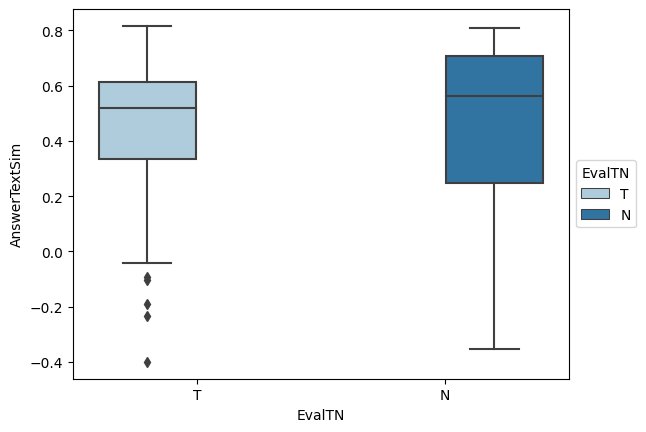

In [99]:
# Creating a boxplot showing answer-text similarity value distrubtion of correct and incorrect answeres
# Evaluator assessment is on X axis
# Cosine similarity between answer and texts is on Y axis
# Colours show different evaluator assessment categories
bxplt = sns.boxplot(x = "EvalTN", y = "AnswerTextSim", hue = "EvalTN", data = results_df, palette = "Paired")

sns.move_legend(bxplt, loc= "center left", bbox_to_anchor=(1, 0.5)) # moving the legend outside the graph


As we can see, the values of the correct answers range from about -0.3 to about 0.9, which means that the cosine similarity of some correct answers to the text is negative. However, this is not unexpected, given that we are talking about a comparison of a longer and a shorter text. 

The values of the similarity between incorrect answers and the text range from about -0.3 to about 0.7, so they are certainly lower than the correct answers. There are no outliers in any category in the distribution of measured cosine similarities.

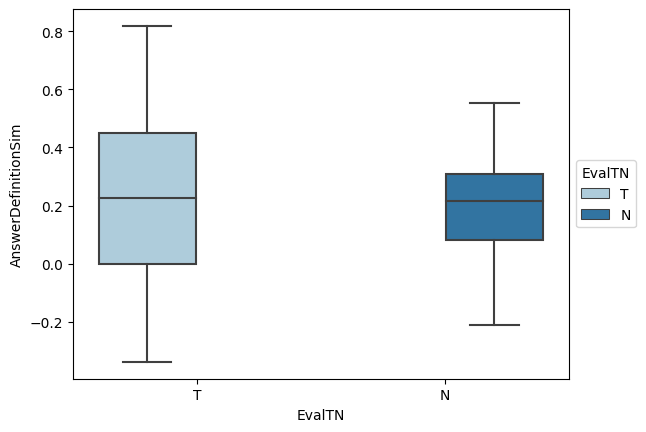

In [100]:
# Creating a boxplot showing answer-correct answer similarity value distrubtion of correct and incorrect answeres
# Evaluator assessment is on X axis
# Cosine similarity between answer and the correct answer is on Y axis
# Colours show different evaluator assessment categories
bxplt = sns.boxplot(x = "EvalTN", y = "AnswerDefinitionSim", hue = "EvalTN", data = results_df, palette = "Paired")
sns.move_legend(bxplt, loc= "center left", bbox_to_anchor=(1, 0.5)) # moving the legend outside the graph

Distribution of values in similarities between participant answers and definitions, ie. of the correct answers (gold standard), is particularly interesting to us. In addition to the similarity with the correct answer, here we compare the semantic similarity of two short texts, and have an insight into how our LSA model actually works on this form.

As we can see, the lower whisker for correct answers extends to lower values than for incorrect answers, but the upper whisker for correct answers also extends to higher values than for incorrect answers. Low values for correct answers may exist due to short answers that are correct. There are no outliers in the measured similarities.

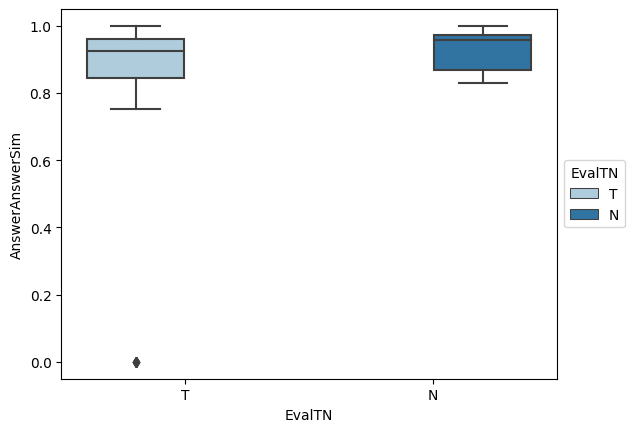

In [101]:
# Creating a boxplot showing answer-answer similarity values distrubtion of correct and incorrect answeres
# Evaluator assessment is on X axis
# Cosine similarity of all answers is on Y axis
# Colours show different evaluator assessment categories
bxplt = sns.boxplot(x = "EvalTN", y = "AnswerAnswerSim", hue = "EvalTN", data = results_df, palette = "Paired") 
sns.move_legend(bxplt, loc= "center left", bbox_to_anchor=(1, 0.5)) #  moving the legend outside the graph

Given that we were looking for answers most similar to each other, this distribution is not unexpected. This variable differs from the others, because not only is the cosine similarity between all answers measured, but also, for each answer, we have taken into consideration only the highest similarity.

Outliers with 0 values in the Tačno (T) (*Correct*) category are very short answers consisting of only 1-2 words.

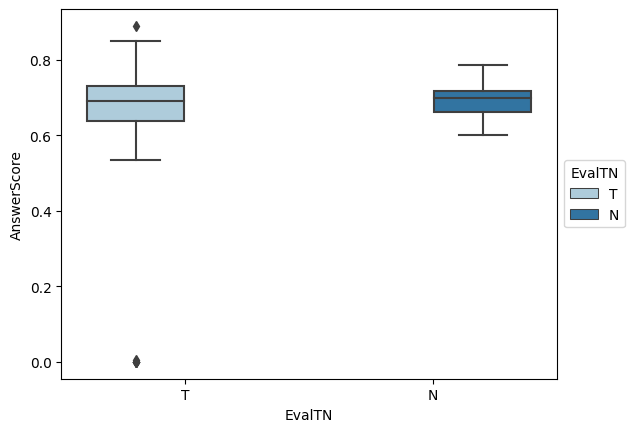

In [102]:
# Creating a boxplot showing answe score value distrubtion of correct and incorrect answeres
# Evaluator assessment is on X axis
# Answer score values are on Y axis
# Colours show different evaluator assessment categories
bxplt = sns.boxplot(x = "EvalTN", y = "AnswerScore", hue = "EvalTN", data = results_df, palette = "Paired")
sns.move_legend(bxplt, loc= "center left", bbox_to_anchor=(1, 0.5)) # moving the legend outside the graph

In the final answer score, we again got lower values for correct answers than for incorrect answers, but the upper whisker extends even above 0.9 and the lower one to around 0.5, while for incorrect answers values range between 0.5 and 0.7 , which is quite a high total score for incorrect answers. 

However, as we said, the highest value was taken for the similarity between answers for both correct and incorrect answers, so this may be the reason for the high total score of incorrect answers, since the arithmetic mean of the obtained cosine similarities for each answer was taken into account.

For incorrect answers we have no outliers, while for correct answers we have several, with values between around 0.

In [103]:
# Checking frequency of each value in the five-category evaluator assessment 
eval_legend = ["netacan odgovor", "deo odgovora je tacan", "odgovor je nepotpun", # creating a legend for assessment values
               "odgovor je gotovo sasvim tacan", "odgovor je u potpunosti tacan"]

eval_count = pd.DataFrame({"Ocena" : results_df["ProcenaEval"].unique(), # column showing unique values in five-category evaluator assessment variable
                           "Frekvencija" : results_df["ProcenaEval"].value_counts()} # column showing value frequencies                       
                          ).sort_values(by = "Ocena").reset_index().drop(columns = "index") # sorting by grade, resetting index, dropping the old index
eval_count["Znacenje ocene"] = eval_legend # creating a column with a lengend for the grades
# Displaying the dataframe
eval_count

,Ocena,Frekvencija,Znacenje ocene
0,1,5,netacan odgovor
1,2,17,deo odgovora je tacan
2,3,21,odgovor je nepotpun
3,4,22,odgovor je gotovo sasvim tacan
4,5,7,odgovor je u potpunosti tacan


As we can see, the grades with the highest frequency in the corpus are 2, 3 and 4, while grades 1 and 5 are much less frequent. This should be taken into account when interpreting the distribution of response cosine similarity values according to these categories.

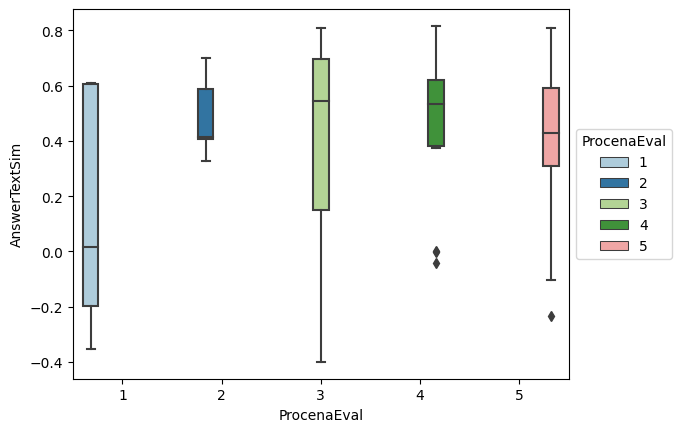

In [104]:
# Creating a boxplot showing answer-text similarity value distrubtion throguh grades 1-5
# Evaluator assessment is on X axis
# Cosine similarity between answer and texts is on Y axis
# Colours show different evaluator assessment categories
bxplt = sns.boxplot(x = "ProcenaEval", y = "AnswerTextSim", hue = "ProcenaEval", data = results_df, palette = "Paired")
sns.move_legend(bxplt, loc= "center left", bbox_to_anchor=(1, 0.5)) # moving the legend outside the graph

In the answer-text similarity, we have the largest range in the values of categories 3 and 5. The answers graded with 1 have the lowest values, around -0.3. Outliers are found in answers graded with 4 and 5, whose value is between 0.2 and 0. For grade 4, these are answers to questions(*chemical weathering*) and *convergent*.

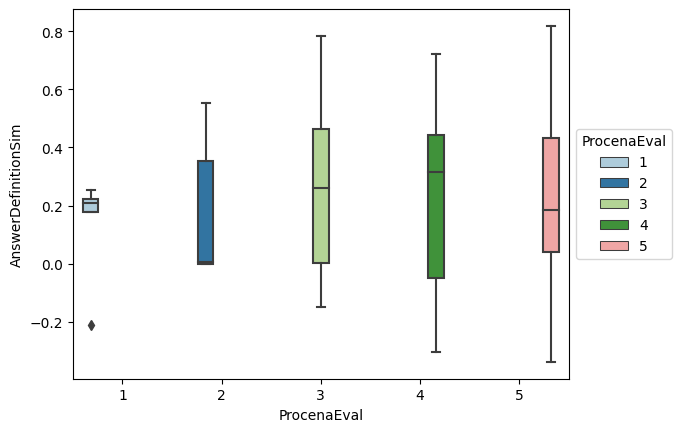

In [105]:
# Creating a boxplot showing answer-correct answer similarity value distrubtion throguh grades 1-5
# Evaluator assessment is on X axis
# Cosine similarity between answer and the correct answer is on Y axis
# Colours show different evaluator assessment categories
bxplt = sns.boxplot(x = "ProcenaEval", y = "AnswerDefinitionSim", hue = "ProcenaEval", data = results_df, palette = "Paired")
sns.move_legend(bxplt, loc= "center left", bbox_to_anchor=(1, 0.5)) # moving the legend

In the answer-correct answer similarity, the largest range in values can be observed in the answers rated as completely correct (5). Completely correct answers have the highest and lowest similarities with the correct answer.

Low similarity values are spotted in answers where a participant used words synonymous to those used in the correct answer when defining the target word. An outlier is observed in grade 2, with a value of around 0.6, and it is the answer to the question *yield*.

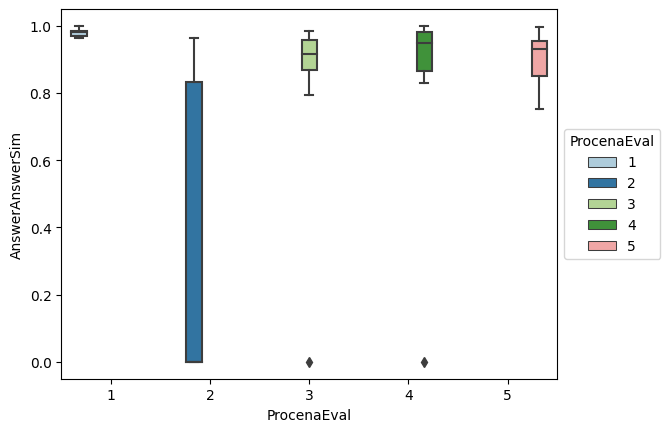

In [106]:
# Creating a boxplot showing similarity value distrubtion of all answers between grade 1 to 5
# Evaluator assessment is on X axis
# Cosine similarity between answer and the correct answer is on Y axis
# Colours show different evaluator assessment categories
bxplt = sns.boxplot(x = "ProcenaEval", y = "AnswerAnswerSim", hue = "ProcenaEval", data = results_df, palette = "Paired")
sns.move_legend(bxplt, loc= "center left", bbox_to_anchor=(1, 0.5)) # moving the graph

In similarity of all answers, we have the largest range of values for category 2, while the values in cateogires 3, 4 and 5 are quite similar. It is interesting that the answers rated as completely incorrect have a similarity of almost 1.

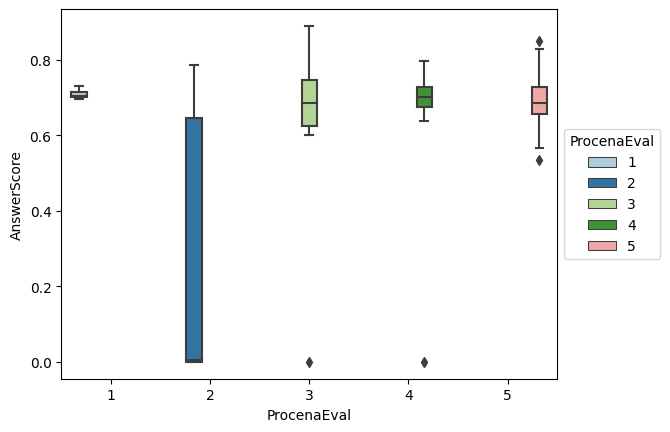

In [107]:
# Creating a boxplot showing answer value distrubtion between grades 1 to 5
# Evaluator assessment is on X axis
# Cosine similarity between answer and the correct answer is on Y axis
# Colours show different evaluator assessment categories
bxplt = sns.boxplot(x = "ProcenaEval", y = "AnswerScore", hue = "ProcenaEval", data = results_df, palette = "Paired")
sns.move_legend(bxplt, loc= "center left", bbox_to_anchor=(1, 0.5)) # moving the legend

Finally, the distribution of values in the final score of the answers is most scattered for answers with a score of 2, and most homogenous for answers with a score of 1. Higher scores have relatively similar final scores, and outliers with a value around 0 are found in scores of 3 and 4. These are short answers whose vectors are 0.

[Text(0.5, 25.722222222222214, 'Процена евалуатора'),
 Text(498.9494949494949, 0.5, 'Сличност')]

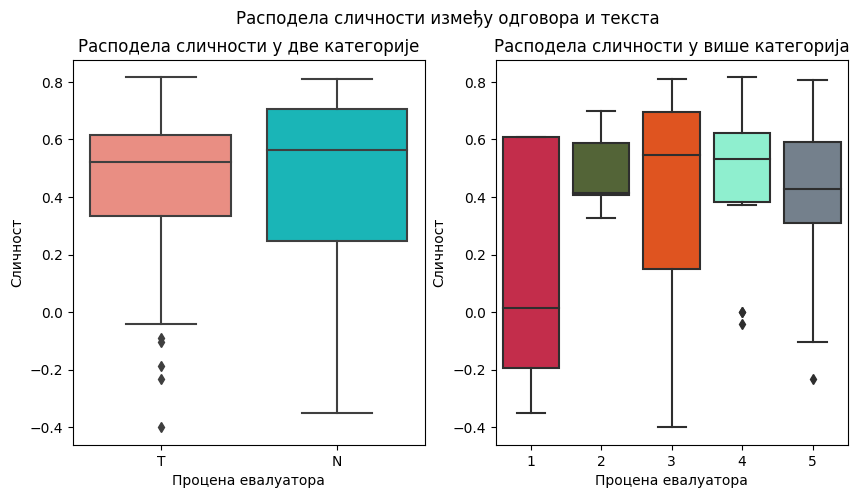

In [108]:
# Creating a graph showing value distribution for both two and five category grades for answer-text similarity 
# answer- text similarity variable
X = results_df["EvalTN"] # setting a two-category evaluator assessment as the X axis value for the first graph
X1 = results_df["ProcenaEval"] # setting a five-category evaluator assessment as the X axis value for the second graph
Y = results_df["AnswerTextSim"] # setting Y axis value
colors1 = ["salmon", "darkturquoise"] # setting colours for the first graph
colors2 = ["crimson", "darkolivegreen", "orangered", "aquamarine", "slategray"] # setting colours for the second graph
figure1, axes1 = plt.subplots(1, 2, sharex=False, figsize=(10, 5)) # adding figure 1
figure1.suptitle("Расподела сличности између одговора и текста") # adding headline for the entire figure
axes1[0].set_title("Расподела сличности у две категорије") # adding headline for the first graph
axes1[1].set_title("Расподела сличности у више категорија") # adding headline for the second graph

fig1 = sns.boxplot(ax = axes1[0], x = X, y = Y, data = answers_final, palette = colors1).set(xlabel = "Процена евалуатора", ylabel = "Сличност") # creating the first graph
fig1 =sns.boxplot(ax = axes1[1], x = X1, y = Y, data = answers_final, palette = colors2).set(xlabel = "Процена евалуатора", ylabel = "Сличност") # creating the second graph
# Saving the figure as a .png file (image)
figure1.savefig("AnswTxtPlt.png")
# Displaying the figure
fig1

[Text(0.5, 25.722222222222214, 'Процена евалуатора'),
 Text(498.9494949494949, 0.5, 'Сличност')]

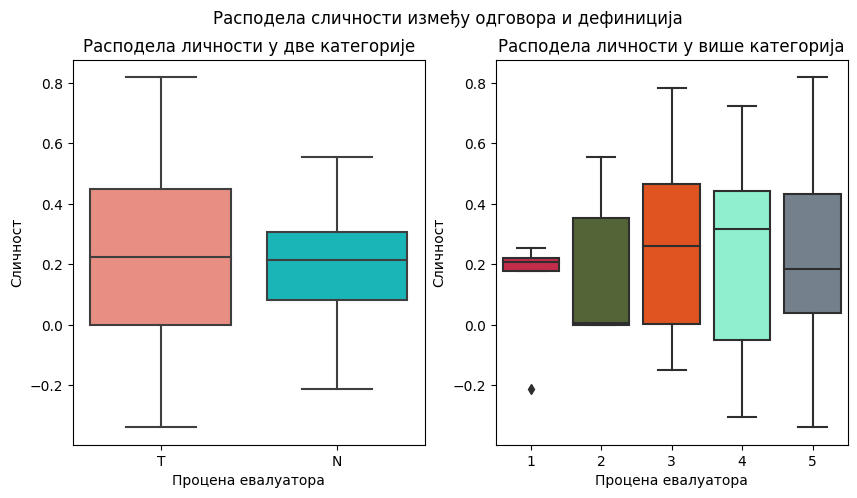

In [109]:
# Creating a graph showing value distribution for both two and five category grades for answer-text similarity
# answer-correct answer similarity variable
X = results_df["EvalTN"] # setting 2-cat evaluator assessment as an X axis value of the first graph
X1 = results_df["ProcenaEval"] # setting 5-cat evaluator assessment as an X axis value of the second graph
Y = results_df["AnswerDefinitionSim"] # setting Y axis value

figure2, axes2 = plt.subplots(1, 2, sharex=False, figsize=(10, 5)) # creating a figure with 2 subplots
figure2.suptitle("Расподела сличности између одговора и дефиниција") #adding figure headline
axes2[0].set_title("Расподела личности у две категорије") # adding first graph headline - two-category distrubtion
axes2[1].set_title("Расподела личности у више категорија") # adding first graph headline - five-category distrubtion
fig2 = sns.boxplot(ax = axes2[0], x = X, y = Y, data = answers_final, palette = colors1).set(xlabel= "Процена евалуатора", ylabel = "Сличност") # creating a plot for 2-cat distrubiton
fig2 = sns.boxplot(ax = axes2[1], x = X1, y = Y, data = answers_final, palette = colors2).set(xlabel= "Процена евалуатора", ylabel = "Сличност") # creating a plot for 5-cat distrubiton

# Saving the figure as a .png file
figure2.savefig("AnswDefPlt.png")
# Displaying the figure
fig2

[Text(0.5, 25.722222222222214, 'Процена евалуатора'),
 Text(510.4494949494949, 0.5, 'Сличност')]

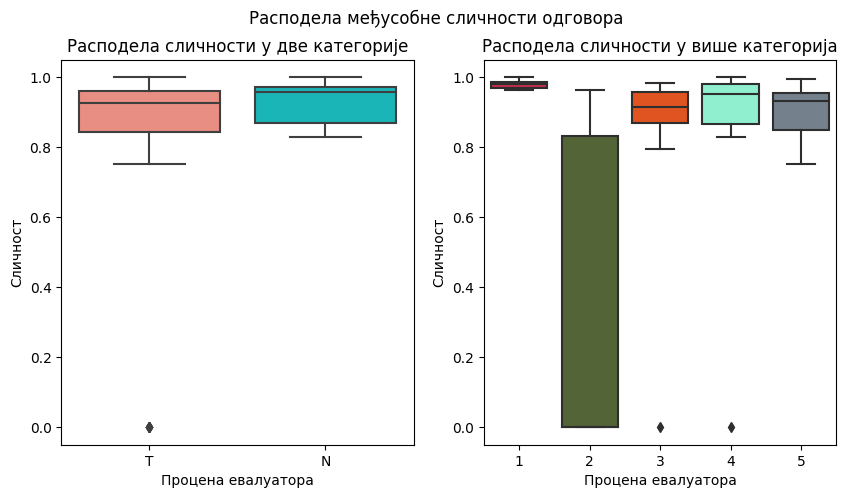

In [110]:
# Creating a graph showing value distribution for both two and five category grades for answer-text similarity
# similarity of all answers variable
X = results_df["EvalTN"] # setting 2-cat evaluator assessment as an X axis value of the first graph
X1 = results_df["ProcenaEval"] # setting 5-cat evaluator assessment as an X axis value of the first graph
Y = results_df["AnswerAnswerSim"] # setting Y axis value

figure3, axes3 = plt.subplots(1, 2, sharex=False, figsize=(10, 5)) #creating a figure with two sublots
figure3.suptitle("Расподела међусобне сличности одговора") # adding figure headline
axes3[0].set_title("Расподела сличности у две категорије") # adding first plot headline - 2-cat distribution
axes3[1].set_title("Расподела сличности у више категорија") # adding second plot headline - 5-cat distribution
# creating a plot for 2-cat distrubiton
fig3 = sns.boxplot(ax = axes3[0], x = X, y = Y, data = answers_final, palette = colors1).set(xlabel = "Процена евалуатора", ylabel = "Сличност") 
# creating a plot for 5-cat distrubiton
fig3 = sns.boxplot(ax = axes3[1], x = X1, y = Y, data = answers_final, palette = colors2).set(xlabel = "Процена евалуатора", ylabel = "Сличност")
# Saving the figure as a .png file
figure3.savefig("AnswAnswPlt.png")
# Displaying the figure
fig3

[Text(0.5, 25.722222222222214, 'Процена евалуатора'),
 Text(510.4494949494949, 0.5, 'Сличност')]

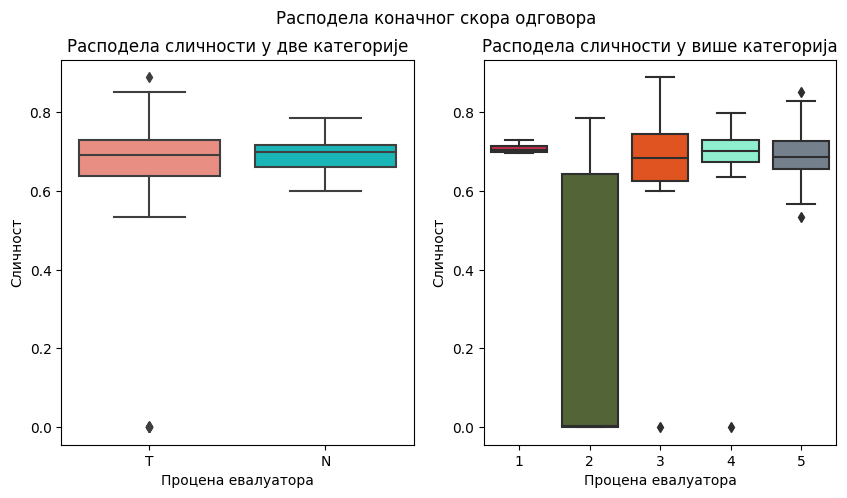

In [111]:
# Creating a graph showing value distribution for both two and five category grades for answer-text similarity
# answer score variable
X = results_df["EvalTN"] # setting 2-cat evaluator assessment as an X axis value of the first graph
X1 = results_df["ProcenaEval"] # setting 5-cat evaluator assessment as an X axis value of the first graph
Y = results_df["AnswerScore"] # setting Y axis value
figure4, axes4 = plt.subplots(1, 2, sharex=False, figsize=(10, 5)) #creating a figure with two sublots
figure4.suptitle("Расподела коначног скора одговора") # adding figure headline
axes4[0].set_title("Расподела сличности у две категорије") # adding first plot headline - 2-cat distribution
axes4[1].set_title("Расподела сличности у више категорија") # adding second plot headline - 5-cat distribution
# creating a plot for 2-cat distrubiton
fig4 = sns.boxplot(ax = axes4[0], x = X, y = Y, data = answers_final, palette = colors1).set(xlabel = "Процена евалуатора", ylabel = "Сличност") 
# creating a plot for 5-cat distrubiton
fig4 = sns.boxplot(ax = axes4[1], x = X1, y = Y, data = answers_final, palette = colors2).set(xlabel = "Процена евалуатора", ylabel = "Сличност") 

# Saving the figure as a .png file
figure4.savefig("AnswScrPlt.png")
# Displaying the figure
fig4

# Answer classification using KNN

After measuring cosine similarities and obtaining answer score for each of the answers in the data, and analyzing the results, we will classify the answers according to 2- and 5-category evaluator assessment. 

For the two-category classification, our categories are Tačno (T) (*Correct*) and Netačno (N) (*Incorrect*)For the five-category evaluator assessment the following scale is used:

*   1 - incorrect 
*   2 - a part of an answer is correct
*   3 - incomplete answer
*   4 - almost completely correct
*   5 - completely correct

For KNN model evaluation, precision, recall and F1 score will be used. The model assessment will be compared with the evaluator assessment. 

We opted for using [KNN]( https://medium.com/analytics-vidhya/summary-of-knn-algorithm-when-used-for-classification-4934a1040983#:~:text=The%20main%20advantage%20of%20KNN,can%20be%20a%20suitable%20algorithm) because it is a non-parametric model, and it is not sensitive to outlayers. Also, using KNN we can do both binary and multinomial classification. 

KNN model was [implemented](https://www.geeksforgeeks.org/ml-implementation-of-knn-classifier-using-sklearn/ 
) using the SciKit-Learn Python library. je implementiran korišćenjem bibloteke `Scikit-Learn`. 




## Binary answer classification

First, we will classify the answer in two categories,  Tačno (T) (*Correct*) and Netačno (N) (*Incorrect*). From the results dataframe, we are extracting answer score variable, and paring each answer with its evaluation label. After this, we will split the data into the training and test set, in ratio of 0.8-0.2 (i.e. 80% train, 20% test).

In [112]:
# Importing libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import seaborn as sns

# Splitting the data into test and training set
# removing the unnecessary columns from the results df
results_final = results_df.drop(columns = ["AnswerDefinitionSim", "AnswerTextSim", 
                                           "AnswerAnswerSim", "IspitanikID",	"PitanjeID",	
                                           "Pitanje",	"Odgovor", "MoodleTN", "ProcenaEval"])
y = results_final["EvalTN"] # creating a y variable with labels - evaluator answer assmessment
X = results_final.drop(columns = "EvalTN") # creating an x variable with classification criteria - answer score
# splitting the data into test and training set in 0.8-0.2 (80% train-20% test) ratio
X_train, X_test, y_train, y_test = train_test_split( 
             X, y, test_size = 0.2, random_state = 42)

# Checking the number of values in the test and training set
print("Training set:", len(X_train))
print("Test set:", len(X_test))


Training set: 57
Test set: 15


Onace we have obtained classificatoin labelas and criteria, and divided the data into a test and a training set, the model is ready for training. 

In order to see how the model works with different values of K, that is, with different numbers of nearest neighbors taken into account when classifying each value, we try values of K between 2 and 21.

In [113]:
# Training our KNN model
K = [] # creating an empty list for values of K
training = [] # creating an empty list for the training set
test = [] # creating an empty list for the test set
scores = {} # creating a dictionary for model precision

# Implementing the model with K values in range from 2 to 21
for k in range(2, 21):
    clf = KNeighborsClassifier(n_neighbors = k) # setting model parameters
    clf.fit(X_train, y_train) # fitting the model on the training set
    training_score = clf.score(X_train, y_train) # predicting values on training set
    test_score = clf.score(X_test, y_test) # predicting values on test set
    K.append(k) # adding K values
    training.append(training_score) # appending model precision for the training set
    test.append(test_score) # appending model precision for the test set
    scores[k] = [training_score, test_score] # creating a dictionary where key is K value 
                                             # and values are the obtained model precision for the training and test set

# Displaying the results for different K values
for keys, values in scores.items():
    print("Model precision for value of K = ", keys, ':', values)

Model precision for value of K =  2 : [0.8421052631578947, 0.4]
Model precision for value of K =  3 : [0.8596491228070176, 0.7333333333333333]
Model precision for value of K =  4 : [0.8771929824561403, 0.7333333333333333]
Model precision for value of K =  5 : [0.8596491228070176, 0.7333333333333333]
Model precision for value of K =  6 : [0.8596491228070176, 0.7333333333333333]
Model precision for value of K =  7 : [0.8596491228070176, 0.7333333333333333]
Model precision for value of K =  8 : [0.8596491228070176, 0.7333333333333333]
Model precision for value of K =  9 : [0.8596491228070176, 0.7333333333333333]
Model precision for value of K =  10 : [0.8596491228070176, 0.7333333333333333]
Model precision for value of K =  11 : [0.8596491228070176, 0.7333333333333333]
Model precision for value of K =  12 : [0.8596491228070176, 0.7333333333333333]
Model precision for value of K =  13 : [0.8596491228070176, 0.7333333333333333]
Model precision for value of K =  14 : [0.8596491228070176, 0.7

As we can see, when the value of k is greater than 5, the accuracy of the model starts to decrease. However, in order to determine exactly which of the values between 1 and 5 is the best for our model, we will visualize the obtained results for the test and training set, and then overlay the two plots to get the best value of K.

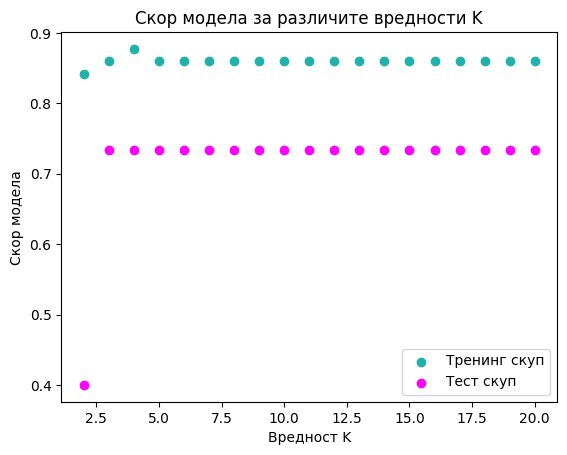

In [114]:
# Creating a plot showing model precision for different values of K for the training and test set
plt.scatter(K, training, color ='lightseagreen', label = "Тренинг скуп") # scatter plot for the training set
plt.scatter(K, test, color ='fuchsia', label = "Тест скуп") # scatter plot for the test set
plt.title("Скор модела за различите вредности K") # plot headline
plt.xlabel("Вредност K") # setting X axis label - k values
plt.ylabel("Скор модела") # setting Y axis label - model precision
plt.legend() # creating a legend
ax.figure.savefig("KNN2CatALL.png") # saving the plot as a .png file
plt.show() # displaying the plot

As we can see, model precision on the training and test set is closest when the value of K is approximately equal to 5. Therefore, we set this as the value of K, and implement our model.

In [115]:
# Implementing the model
k = 5 # setting K value
model = KNeighborsClassifier(n_neighbors= k ) # setting model parameters
train = model.fit(X_train, y_train) # fitting on the training set
predict = model.predict(X_test) # predicting on the test set

# Printing the predicted categories
print(predict)

['T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T' 'T']


## Evaluation of the binary classification KNN algorithm

After determining the value of k, training and testing the model, we evaluate the model's precision, recall, and F1 score.

In [116]:
# Importing libraries
from matplotlib.widgets import RectangleSelector
from sklearn import metrics

# Calculating precision and recall
precision = metrics.precision_score(y_test, predict, 
                                    average="binary", pos_label = "T")
recall = metrics.recall_score(y_test, predict, 
                              average="binary", pos_label = "T") 

# Computing F1 score
f1 = metrics.f1_score(y_test, predict, 
                      average="binary", pos_label = "T")

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Precision: 0.7333333333333333
Recall: 1.0
F1 score: 0.846153846153846


In [117]:
# Importing confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Creating a confusion matrix
result = confusion_matrix(y_test, predict)
print("Confusion matrix:")
print(result)

# Looking at model evaluation by each category
result1 = classification_report(y_test, predict)
print("Model evaluation:",)
print(result1)

# Checking accuracy score
result2 = accuracy_score(y_test,predict)
print("Accuracy:", result2)

Confusion matrix:
[[ 0  4]
 [ 0 11]]
Model evaluation:
              precision    recall  f1-score   support

           N       0.00      0.00      0.00         4
           T       0.73      1.00      0.85        11

    accuracy                           0.73        15
   macro avg       0.37      0.50      0.42        15
weighted avg       0.54      0.73      0.62        15

Accuracy: 0.7333333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we can see, we got a model with quite high precision and call. It is interesting that we got the same values for precision and recall. 

However, it should be taken into account that the size of our test set is extremely small and consists of only 15 observations, and that the classification is done in only two categories. We cannot claim with certainty that such results would be obtained for a larger data set.

In addition, as the incorrect category is underrepresented on our data, model precision, recall and F1 score for this category is 0, meaning that our model is very bad at detecting incorrect answers.

Looking at the value distribution of answer score between correct and incorrect answers, we can see that values are not all that different, which assuredly made it harder for the model to differentiate between the two.

## Multinomial answer classification

Now, we will classify the answers according to a five-category evaluator assessment that we previosly discribed. Same as in binary classification, we will frist make variables with the classification labes and criteria, and then split the data in training and test set, in the same ratio as before - 0.8-0.2 training and test, respectively.

In [118]:
# Splitting the data into training and test set

# dropping the unnecessary columns
results_final = results_df.drop(columns = ["AnswerDefinitionSim", "AnswerTextSim", 
                                           "AnswerAnswerSim", "IspitanikID",	"PitanjeID",	
                                           "Pitanje",	"Odgovor", "MoodleTN", "EvalTN"]) 
y = results_final["ProcenaEval"] # making a variable with labels
X = results_final.drop(columns = "ProcenaEval") # making a variable with classification criteria
# splitting into training and test set in 80-20 ratio
X_train, X_test, y_train, y_test = train_test_split( 
             X, y, test_size = 0.2, random_state = 42)

# Checking sizes of trainig and test set
print("Number of observations in the training set: ", len(X_train))
print("Number of observations in the test set: ", len(X_test))

Number of observations in the training set:  57
Number of observations in the test set:  15


Again, we will try out K values between 2 and 21 to find the best value for our model.

In [119]:
# Training the model
K = [] # crating an empty list for K values
training = [] # creating an empty list for training set precision
test = [] # creating an empty list for test set precision
scores = {} # creating a dictionary for model score

# Implementing the model with K values form 2 to 21
for k in range(2, 21):
    clf = KNeighborsClassifier(n_neighbors = k) # setting model parameters
    clf.fit(X_train, y_train) # fitting the model on the training set
    training_score = clf.score(X_train, y_train) # predicting on training set
    test_score = clf.score(X_test, y_test) # predicting on test set
    K.append(k) # appending k values
    training.append(training_score) # appending precision on training set
    test.append(test_score) # appending precision on test set
    scores[k] = [training_score, test_score] # creating a dictionary 
                                              # key - k value
                                              # value - training set predicitons precision, test set predictions precision

# Printing results obtained for different K values
for keys, values in scores.items():
    print("Model precision for value of K = ", keys, ':', values)

Model precision for value of K =  2 : [0.5964912280701754, 0.3333333333333333]
Model precision for value of K =  3 : [0.5263157894736842, 0.3333333333333333]
Model precision for value of K =  4 : [0.543859649122807, 0.26666666666666666]
Model precision for value of K =  5 : [0.47368421052631576, 0.4]
Model precision for value of K =  6 : [0.5087719298245614, 0.3333333333333333]
Model precision for value of K =  7 : [0.5263157894736842, 0.3333333333333333]
Model precision for value of K =  8 : [0.49122807017543857, 0.26666666666666666]
Model precision for value of K =  9 : [0.49122807017543857, 0.26666666666666666]
Model precision for value of K =  10 : [0.40350877192982454, 0.3333333333333333]
Model precision for value of K =  11 : [0.38596491228070173, 0.4]
Model precision for value of K =  12 : [0.3333333333333333, 0.4]
Model precision for value of K =  13 : [0.3684210526315789, 0.4]
Model precision for value of K =  14 : [0.3684210526315789, 0.4]
Model precision for value of K =  15

As with the binary classificaiton, we will visualize the results to get a more clear insight into model performance with different K values.

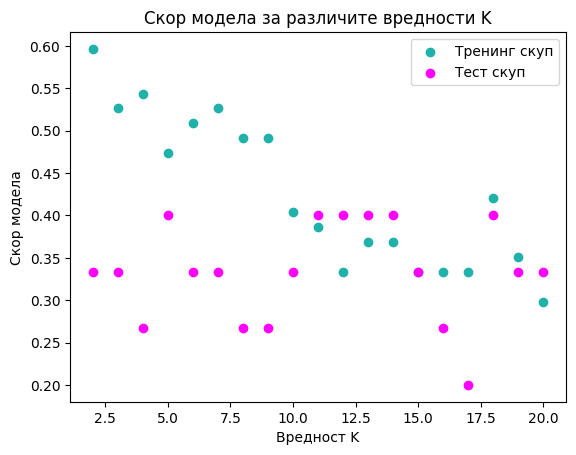

In [120]:
# Creating a plot showing model precision for different values of K for the training and test set
plt.scatter(K, training, color ='lightseagreen', label = "Тренинг скуп") # scatter plot for the training set
plt.scatter(K, test, color ='fuchsia', label = "Тест скуп") # scatter plot for the test set
plt.title("Скор модела за различите вредности K") # plot headline
plt.xlabel("Вредност K") # setting X axis label - k values
plt.ylabel("Скор модела") # setting Y axis label - model precision
plt.legend() # creating a legend
ax.figure.savefig("KNN2CatALL.png") # saving the plot as a .png file
plt.show() # displaying the plot

Kao što vidimo, preciznost modela je svakako daleko manja na test nego na trening skupu, ali gde se najviše preklapa je kada je vrednost k oko 5. Prema tome, dodeljujemo vrednost k = 5, obučavamo i testiramo naš model.

In [121]:
# Implementacija modela
k = 5 #odredjivanje vrednosti K na osnovu dobijenih rezultata
model = KNeighborsClassifier(n_neighbors= k ) # kreiranje modela
train = model.fit(X_train, y_train)
predict = model.predict(X_test)
print(predict)

[2 3 5 1 5 5 1 5 3 3 5 3 1 4 3]


## Evaluation of the multinomial KNN algorithm

Finally, we will evaluate the multinomial classification model, using precision, recall and F1 score.

In [122]:
# source:
# https://towardsdatascience.com/multiclass-classification-using-k-nearest-neighbours-ca5281a9ef76

# Importing confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Creating a confusion matrix
result = confusion_matrix(y_test, predict)
print("Confusion matrix:")
print(result)

# Looking at model evaluation by each category
result1 = classification_report(y_test, predict)
print("Model evaluation:",)
print(result1)

# Checking accuracy score
result2 = accuracy_score(y_test,predict)
print("Accuracy:", result2)

Confusion matrix:
[[0 0 1 0 1]
 [0 1 0 0 0]
 [0 0 2 0 1]
 [1 0 2 0 0]
 [2 0 0 1 3]]
Model evaluation:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         1
           3       0.40      0.67      0.50         3
           4       0.00      0.00      0.00         3
           5       0.60      0.50      0.55         6

    accuracy                           0.40        15
   macro avg       0.40      0.43      0.41        15
weighted avg       0.39      0.40      0.38        15

Accuracy: 0.4


As we can see, our model performs quite poorly when it comes to categories 1, 2 and 4, and has much better results when classifying categories 3 and 5. We assume that the reason for these results is that these two categories are the most represented in our data. 

In general, the accuracy of the model is very poor, with only 0.26. The results would probably be better with more data, where the number of labels for each category is better balanced.

## Wordcould representing unit texts

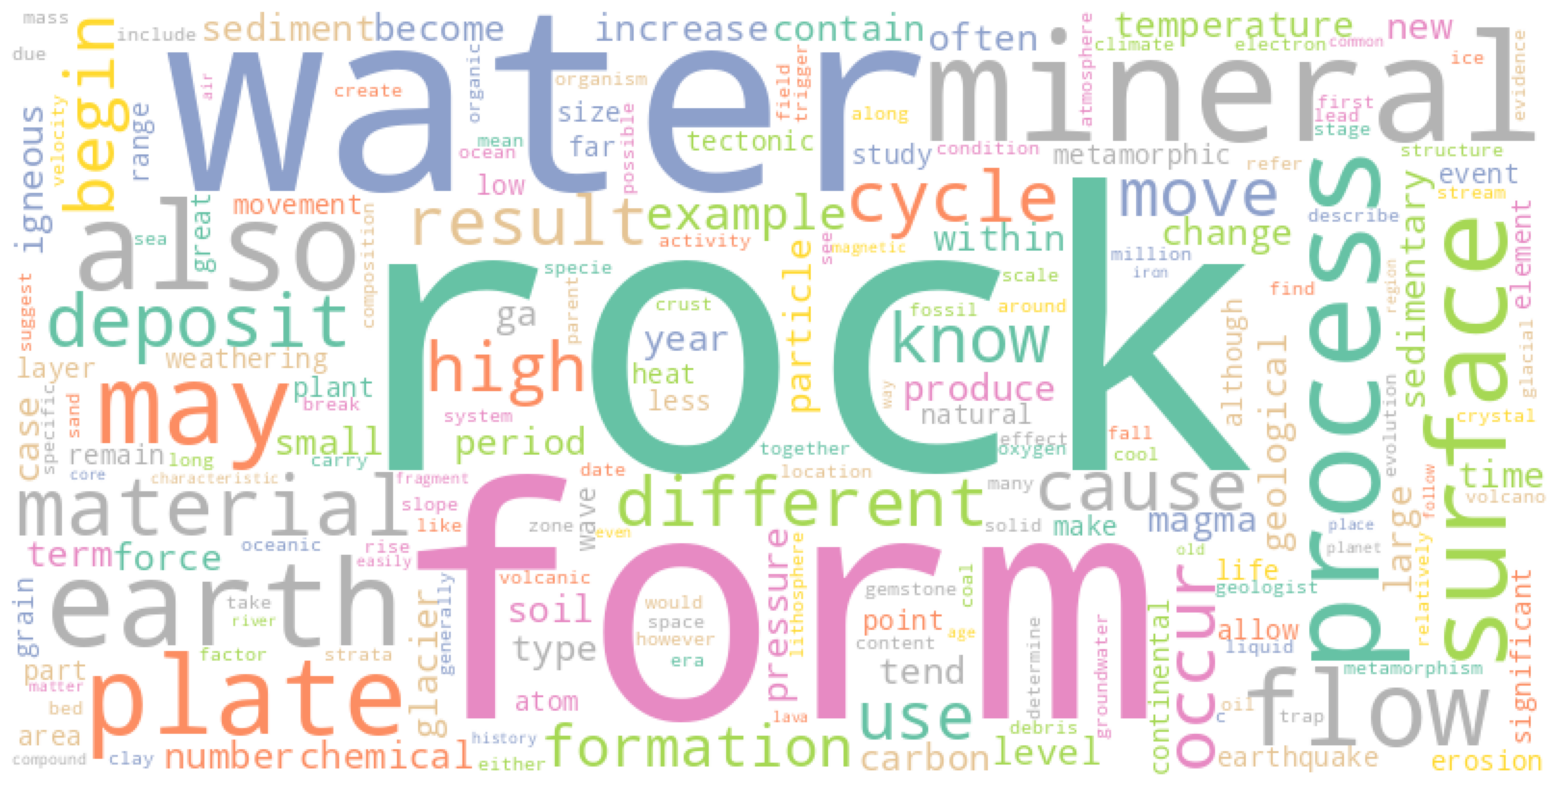

In [123]:
word_cloud = WordCloud(
        width = 800,
        height = 400,
        random_state = 1,
        background_color = "white",
        colormap = "Set2",
        collocations = False,
        stopwords = stop_words,
        ).generate(str(texts_clean))

plt.figure( figsize=(20,10) )
plt.imshow(word_cloud)
plt.axis("off")
plt.show()